## Example for generating images
Shows how to generate new images from the trained VAE


In [1]:
import sys
import matplotlib.pyplot as plt
from skimage import io
import pandas as pd
import numpy as np
import torch
# import torch.optim as optim
from torch.utils.data import DataLoader
from custom_dataset import CustomDataset
# from pytorch_ssim import SSIM #don't use pip installed version, is not maintained
from torchvision import transforms
from VAE_functions import generate_random_images, show_generated_images 
from pathlib import Path
import os

In [2]:
#GPU or CPU
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda")

True


In [3]:
#load actual model
# model = torch.load('model_slurm2.pth') #trained 200 epochs
model = torch.load('model_newimg_upepochs_3.pth') #300 epochs
model.to(device)

VAE(
  (encoder): Encoder(
    (conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
      (2): Conv2d(32, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (5): ReLU()
      (6): Conv2d(128, 256, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (7): ReLU()
      (8): Conv2d(256, 512, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (9): ReLU()
      (10): Conv2d(512, 1024, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (11): ReLU()
    )
    (fc_mu): Linear(in_features=50176, out_features=50, bias=True)
    (fc_logvar): Linear(in_features=50176, out_features=50, bias=True)
  )
  (decoder): Decoder(
    (fc): Linear(in_features=50, out_features=50176, bias=True)
    (deconv): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (1): ReLU()
   

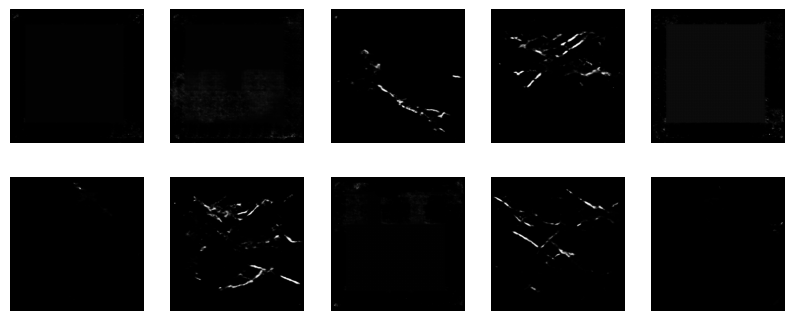

tensor([ 1.2295, -1.1718,  0.5925, -1.1806,  0.5616,  2.3650, -1.3484, -0.3530,
         0.0072, -0.8934,  1.4671, -1.3128,  0.3760,  0.8728, -1.0017,  0.2090,
         0.0896, -0.1427,  2.4618,  0.6409, -1.6405,  0.2145, -1.4379, -0.7159,
         0.3727, -1.6602, -0.3209,  0.7257, -1.6494, -1.0657, -0.4953, -0.4694,
         1.6042, -1.9454,  2.8982, -1.0537,  0.6447, -0.5051,  0.0923, -0.4399,
        -0.1683,  2.6018, -0.2998,  0.9059, -0.2337, -0.5097, -0.6310, -0.5303,
        -0.6725, -0.9723], device='cuda:0')


In [4]:
#This is how to randomly generate crack images
#we want to avoid the completely random part
generated_images_random, vectors = generate_random_images(model, 10, 50, "cuda")
fig = show_generated_images(generated_images_random, 10, None)
print(vectors[0])

In [5]:
# #Load images for testing (old), only duramat-hub images
# pathimages = '/home/nrjost/DuramatCrackImg/'
# df = pd.read_csv(pathimages + 'image_inventory.csv', index_col=[0])

# #Preprocess data as a float 0. to 1.
# def preprocess(impath):
#     dat=io.imread(impath)
#     dat=dat[:,:,:2]/255
#     # dat=dat[:100,:100,:] #testing if cropping the image works
#     # dat = resize(dat, [160, 160])#, anti_aliasing=True) #resize from 400x400 to 100x100
#     return dat.astype('float32')
    
# #All images with cracks
# array=[]
# for i in range(len(df)):
#     if df['has_cracks'].iloc[i]:
#         array.append(preprocess(pathimages + df['maskpaths'].iloc[i]))

# array=np.stack(array)
# print("Size of array with cracked images %s" % str(array.shape))

# # plt.imshow(array[0][:,:,0])
# # plt.imshow(array[0][:,:,1])

# # train=array[:600,:,:,1:2] #second layer contains crack data
# testa=array[600:,:,:,1:2]
# test = CustomDataset(testa)

In [6]:
#load testing batch from new images crack mask using retrained pvvision
#We'll use this testing batch to compare our generated images with and run a t-test
new_pathimages = '/home/nrjost/DuramatCrackImg/emma_pvvision_crack_images/'
root = Path(new_pathimages)
files = os.listdir(root)
files_img = [x for x in files if x.endswith(('tiff'))]
array_new=[]
for i in range(len(files_img)):
    dat=io.imread(f"{root}/{files_img[i]}")
    # dat=dat[:,:,:2]/255
    # dat=dat[:,:,:2]/dat[:,:,1].max
    datmean = dat.mean()
    dat = (dat > datmean).astype(np.float32)
    # dat = dat.astype('float32')
    array_new.append(dat)
array_new = np.stack(array_new)
print("Size of new array with cracked images %s" % str(array_new.shape))

#add new images to training array
# train =  np.concatenate((train, array_new[:,:,:,1:2]), axis = 0)
train = array_new[:-100,:,:,1:2]
testimg = array_new[-99:,:,:,1:2]

#testing batch is of 99 images
test = CustomDataset(testimg)
test_loader = DataLoader(test, batch_size=99, shuffle=True, num_workers=1)


Size of new array with cracked images (1188, 400, 400, 4)


In [7]:
# #feature extraction code
# #Modified code from pvimage
# #Source: https://github.com/cwru-sdle/pvimage
# def features.feature_extraction_crack_mask(images, dfinfo):
#     import pvimage_scripts.bgp_crack_features as bgp_crack_features
#     from skimage.morphology import skeletonize
#     import scipy
#     from skimage.morphology import erosion, dilation, opening, closing, white_tophat
#     dffeatures = pd.DataFrame()
#     testimages = images
    
#     for n, testimage in enumerate(testimages): #testimages
#         gray = testimage
#         gimg = cv2.GaussianBlur(gray,(3,3),0) #11,11 #small works better with bigger images
#         gimg = gimg**(1/2.)
#         gimg = cv2.normalize(gimg, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
#         gimg = gimg.astype(np.uint8)
#         th2 = cv2.adaptiveThreshold(gimg, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,51,2) #original: 51,2
#         # plt.imshow(th2, cmap='gray')
        
#         kernel = np.ones((20,20), np.uint8)
#         blackhat = cv2.morphologyEx(gimg, cv2.MORPH_BLACKHAT, kernel)
#         # plt.figure(figsize=(3,3))
#         # plt.imshow(blackhat, cmap='gray')
#         kernel = np.ones((1,1), np.uint8)
#         blackhat = cv2.morphologyEx(blackhat,cv2.MORPH_OPEN, kernel)
#         mask = cv2.threshold(blackhat, blackhat.max()/8, blackhat.max(), cv2.THRESH_BINARY)[1]
#         mask2 = cv2.morphologyEx(mask,cv2.MORPH_CLOSE, kernel)
#         mask2n = mask2/mask2.max()
#         # plt.figure(figsize=(3,3))
#         # plt.imshow(mask2n, cmap='gray')
        
#         sk = skeletonize(mask2n)
#         # plt.figure(figsize=(3,3))
#         # plt.imshow(sk, cmap='gray')
        
#         sk[0:5,:]=False
#         sk[-5:-1,:]=False
#         sk[:,0:5]=False
#         sk[:,-5:-1]=False
        
#         kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#         sk_enhanced  = cv2.dilate(sk.astype('uint8'), kernel, iterations=3)
#         vector = sk.sum(axis = 0)
#         signal = (vector > np.roll(vector,1)) & (vector > np.roll(vector,-1))
#         top4 = (-vector[signal]).argsort()[:4] # get argmax largest values
#         top4_idx = signal.nonzero()[0][top4] # get their indexes
        
#         blackhat = sk_enhanced
#         # plt.figure(figsize=(3,3))
#         # plt.imshow(blackhat)
        
#         bbrmd2 = blackhat
#         bbrmd2 = cv2.dilate(bbrmd2.astype('uint8'), kernel, iterations=2)
#         # plt.figure(figsize=(3,3))
#         # plt.imshow(bbrmd2)
        
#         opened = opening(bbrmd2)
        
#         props = bgp_crack_features.extract_img_feats(bbrmd=bbrmd2, imgsrc=dfinfo.impath[n]#.split('/')[4]
#         , top_n = 'all', by = 'perimeter', show = False, min_thresh = 100)
#         propnames = 'imgsrc, sa_number, cell_number, cell_type, i, prop.perimeter, slope, prop.convex_area, prop.area, prop.orientation, prop.image'
        
#         listprops = propnames.split(',')

#         for i in range(0, len(props)):
#             names = []
#             values = []
#             for s1,s2 in zip(listprops, props[i]):
#                 # print(s1, ' = ', s2)
#                 names.append(s1)
#                 values.append(s2)
#             dftemp = pd.DataFrame(data = values[:-1]).T
#             dftemp.columns = names[:-1]
#             dffeatures = pd.concat([dffeatures, dftemp], axis=0)
#     return dffeatures

In [8]:
from pvimage import features

In [9]:
#Run modified feature extraction function on all original test images
sys.path.append('/home/nrjost/DuramatCrackImg')
# '/home/nrjost/githome/pvimage/'
# old_pathimages = '/home/nrjost/DuramatCrackImg/'

# dfinfo = pd.read_csv(old_pathimages + 'image_inventory.csv', index_col=[0])
# testimgsreal = array[600:,:,:,1:2]  #to see where they come from check out Cell: "#Load images for testing"

dfinfo = pd.DataFrame()
dfinfo['impath'] = files_img[-99:]
# dfinfo['sa_number'] = 19980
# dfinfo['impath'] = dfinfo['sa_number'].astype('str') + dfinfo['impath']

dffeaturesreal = features.feature_extraction_crack_mask(testimg, dfinfo)

dffeaturesreal.head()

/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimage/pvimage/features.py:59: RuntimeWarning: invalid value encountered in true_divide
  mask2n = mask2/mask2.max()
/home/nrjost/githome/pvimag

cell_number  i  prop.perimeter     slope  prop.convex_area  prop.area  \
0         327  3      106.727922  0.901097               547        512   
0         357  4      107.355339  -0.71392               684        566   
0         357  0      104.426407 -0.872723               653        572   
0        1164  6      483.019336 -1.849976              5943       3050   
0        1164  5      366.568542  4.103142              3174       2070   

   prop.orientation  
0          1.477404  
0         -0.870552  
0         -0.946429  
0          -1.11543  
0          1.467221

In [10]:
#feature extract on output images
model.eval

# Get the VAE outputs for the input images
# for batch in test_loader:
#     batch = torch.tensor(batch)
#     with torch.no_grad():
#         # vae_outputs, _, _ = model(batch)
#         mu, logvar = Encoder(batch)
#         vae_outputs = Decoder(mu)
image_tensors = []
for image in testimg:
    image_tensor = transforms.ToTensor()(image).to(device)
    image_tensors.append(image_tensor)

testtensors = torch.stack(image_tensors)
vae_outputs, _, _ = model(testtensors)


# dfinfo = pd.read_csv(pathimages + 'image_inventory.csv', index_col=[0])
# testimgs = vae_outputs.cpu().squeeze(0).numpy()
testimgs = vae_outputs.cpu().squeeze(0).detach().numpy()
testimg_reshaped = np.reshape(testimgs, (99, 400, 400, 1))

dffeaturesout = features.feature_extraction_crack_mask(testimg_reshaped, dfinfo)

dffeaturesout.head()

torch.Size([99, 1024, 7, 7])


cell_number  i  prop.perimeter     slope  prop.convex_area  prop.area  \
0          26  1     1186.286363  0.020767             17650      12365   
0          26  0     1077.445743 -0.040363             17700      10444   
0          26  9       846.47518  0.601486             11976       8509   
0          26  8      842.747258 -0.073702             12316       6089   
0          26  2      164.041631 -0.427907              1033        842   

   prop.orientation  
0          0.023469  
0         -0.041708  
0          1.172846  
0         -0.125463  
0         -1.534804

/tmp/ipykernel_3995692/2957652712.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


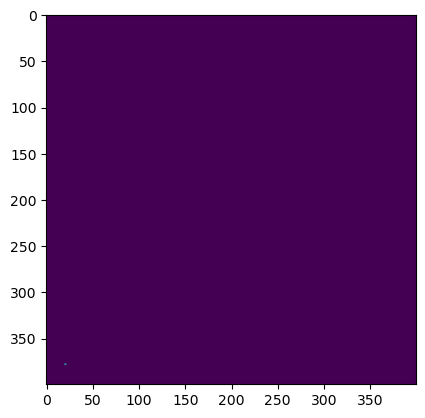

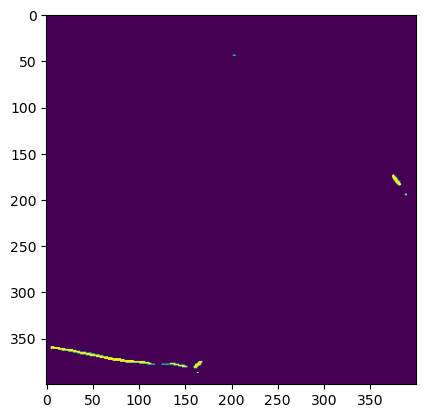

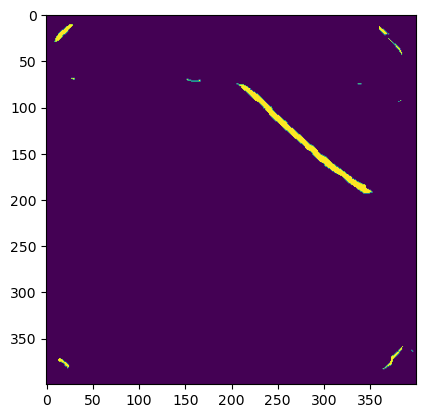

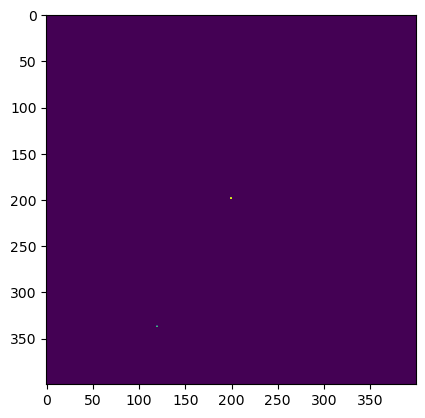

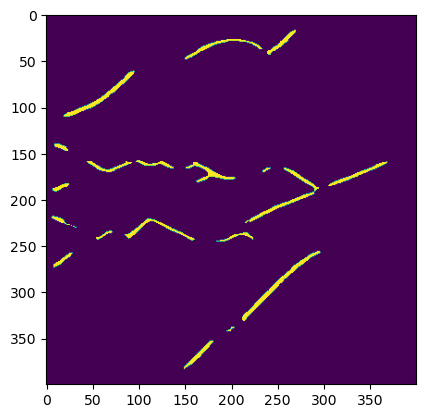

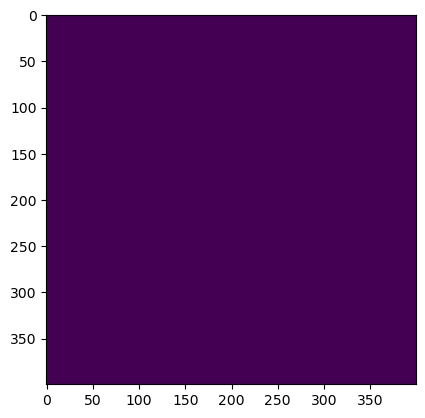

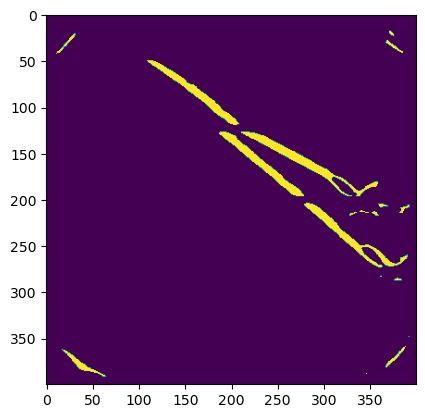

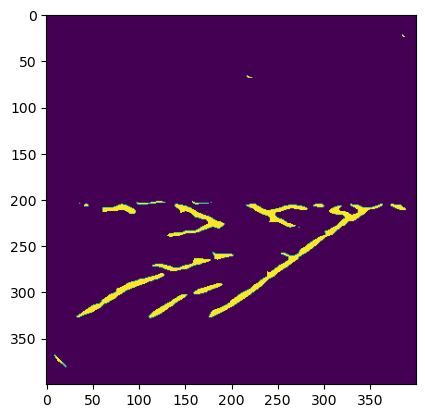

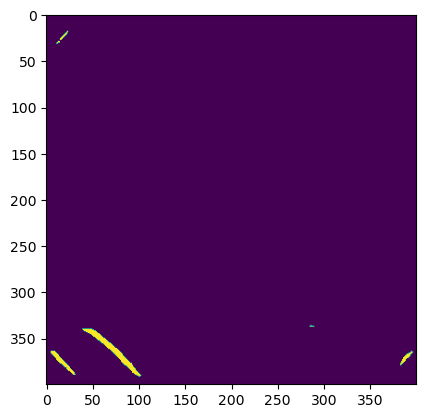

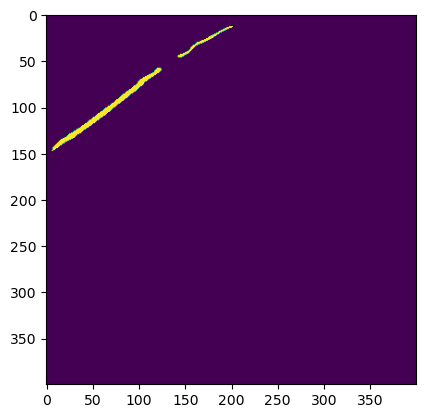

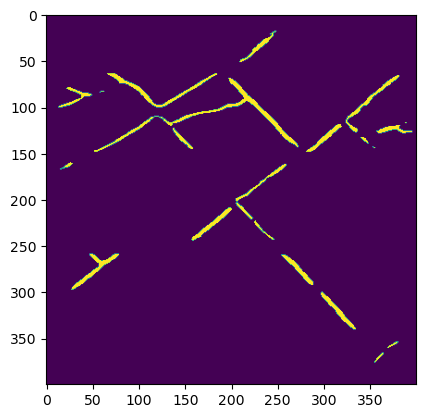

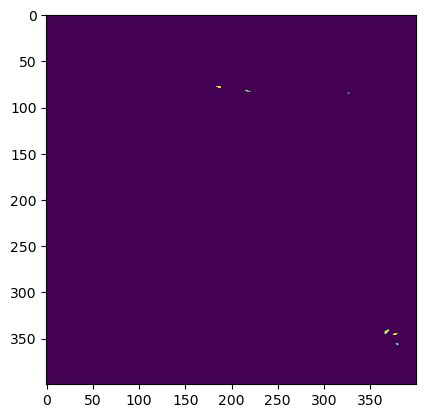

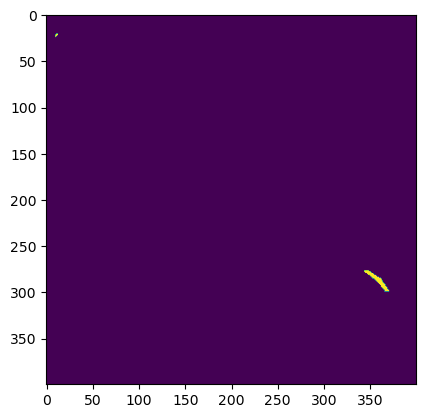

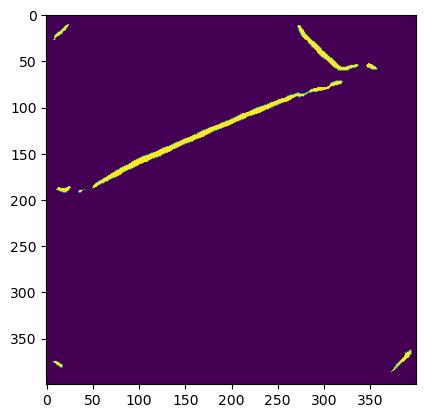

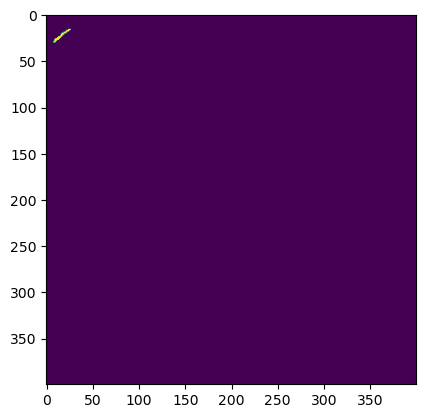

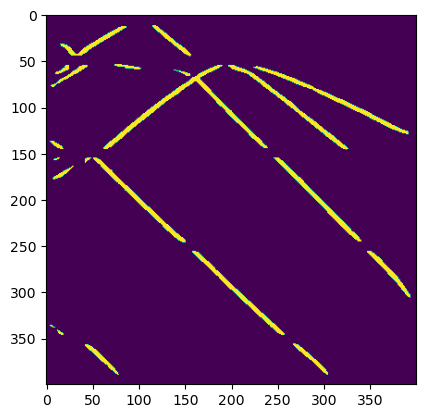

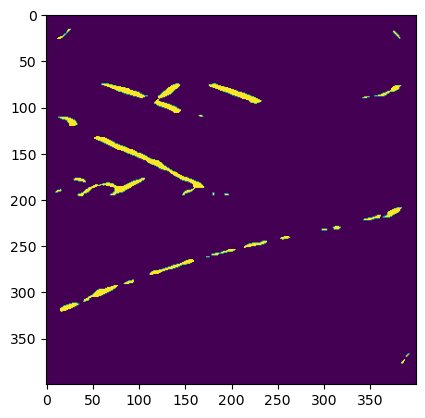

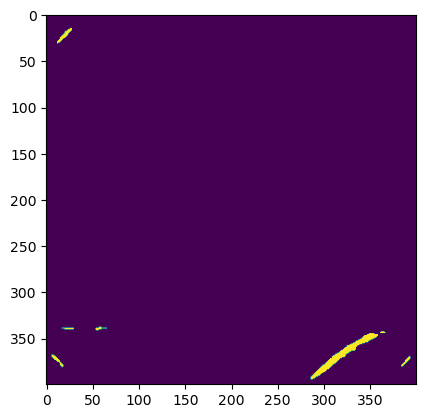

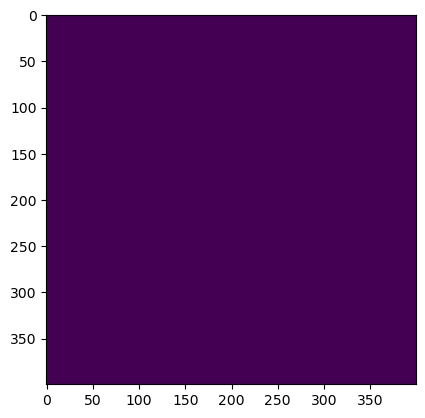

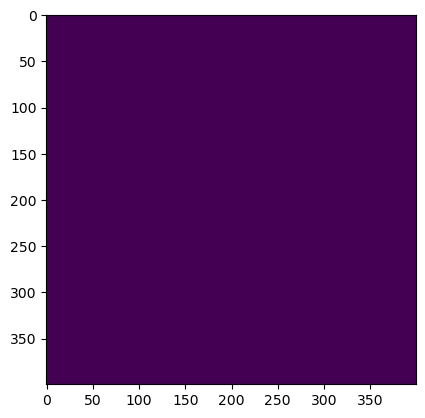

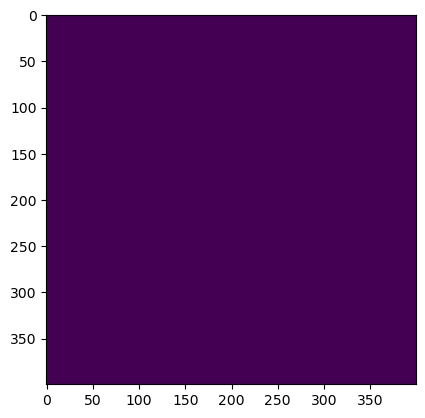

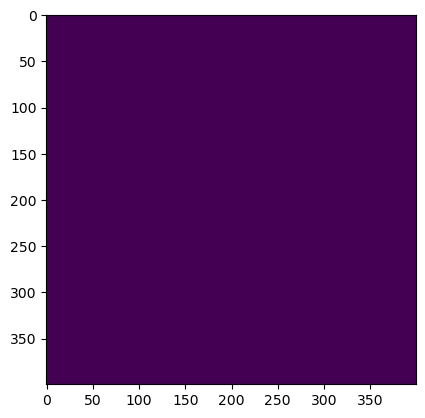

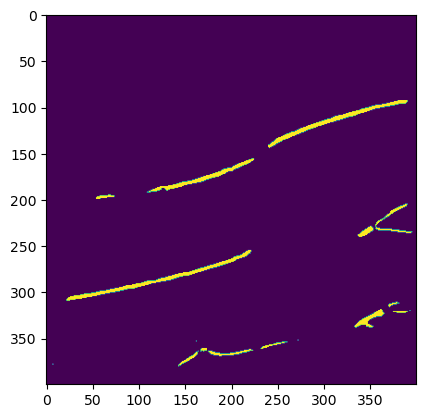

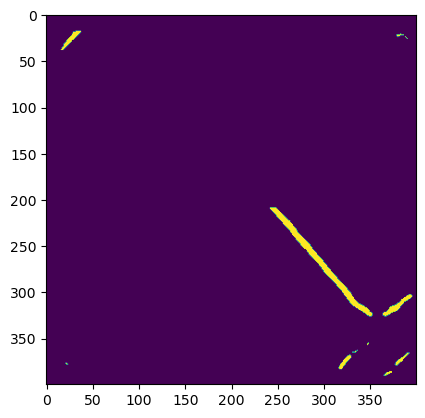

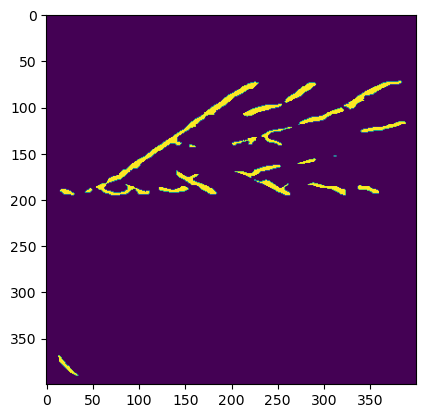

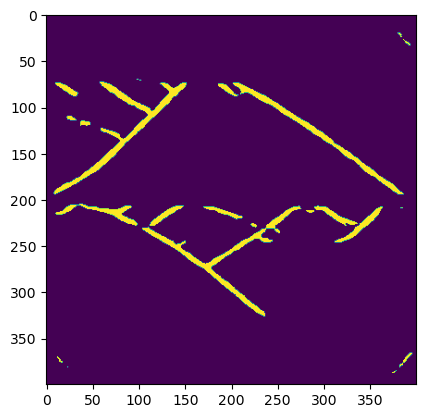

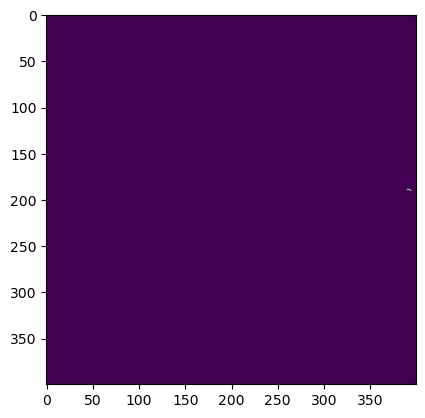

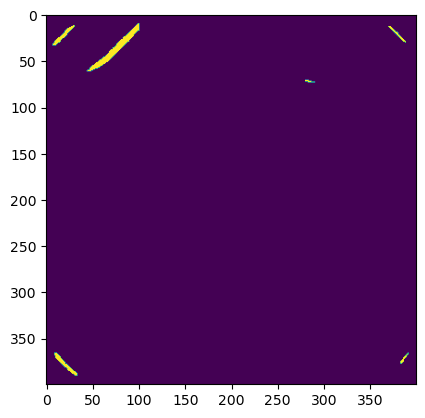

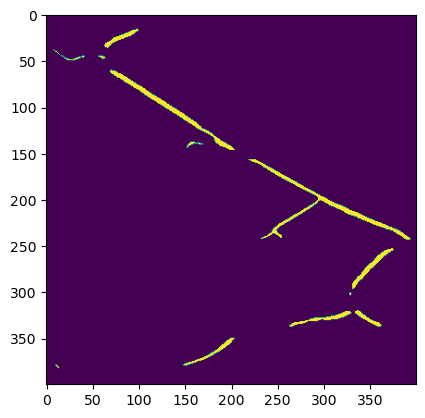

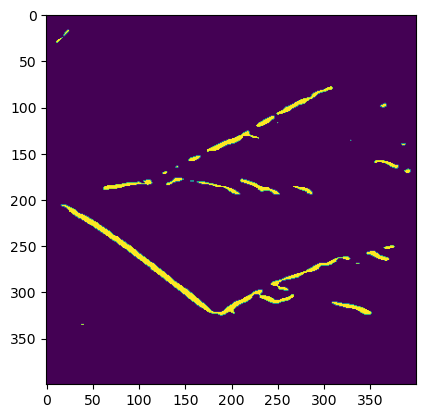

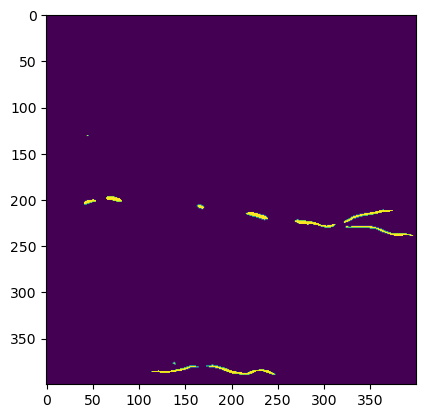

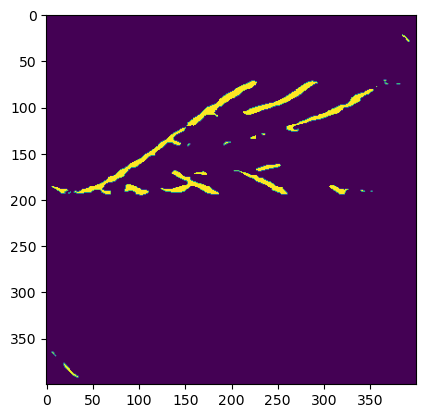

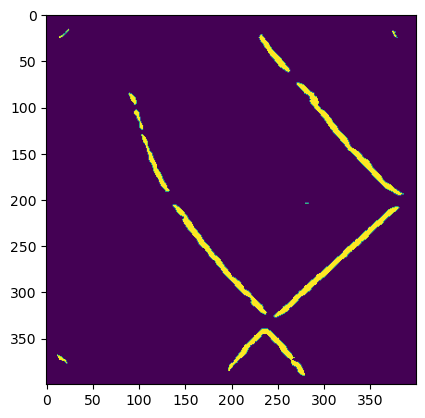

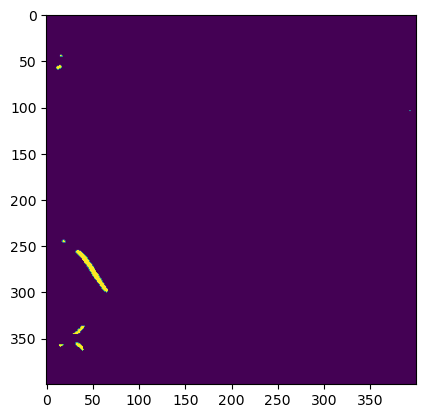

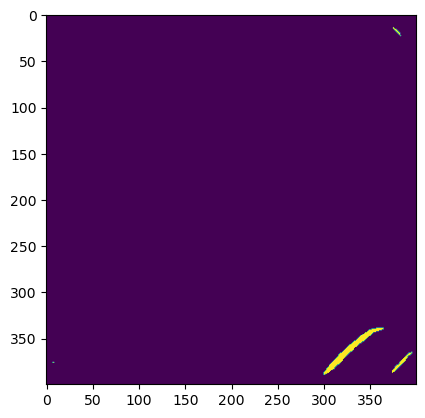

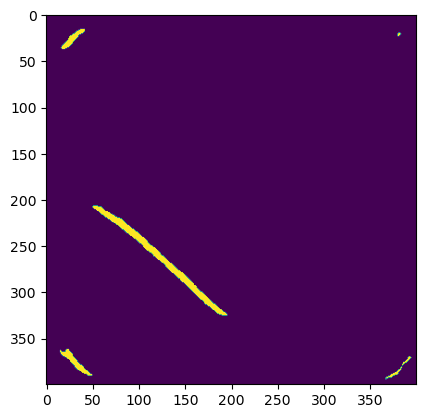

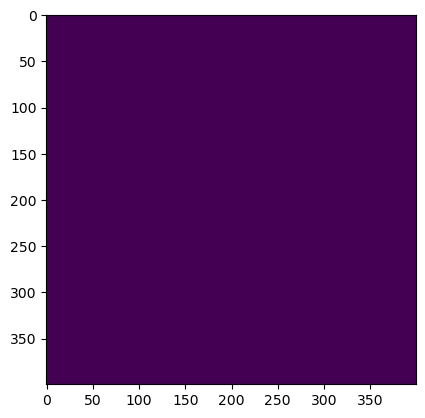

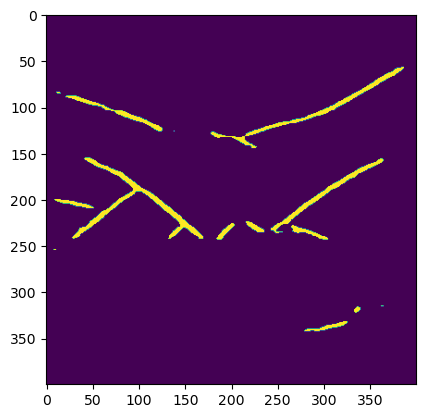

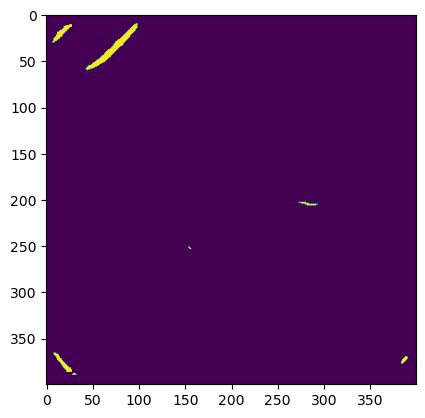

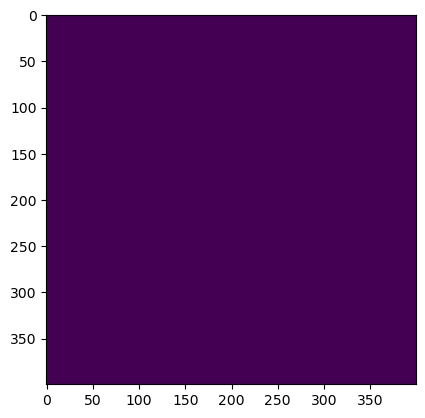

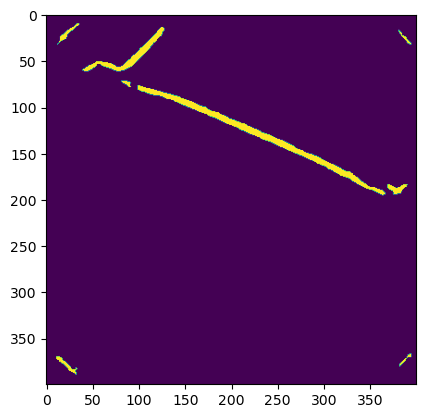

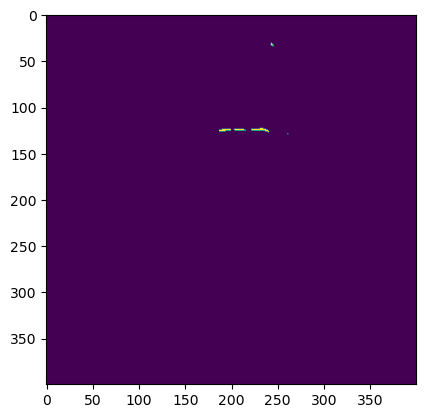

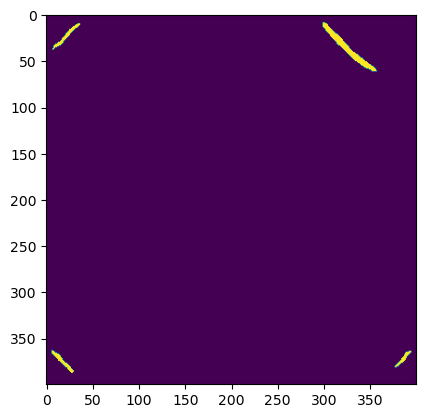

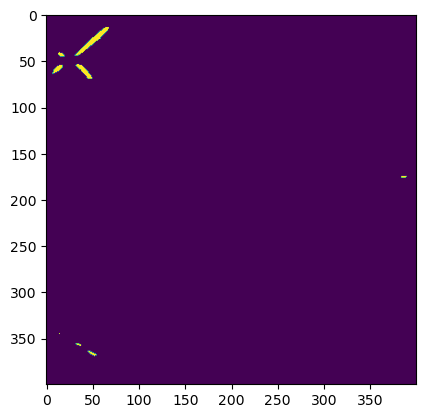

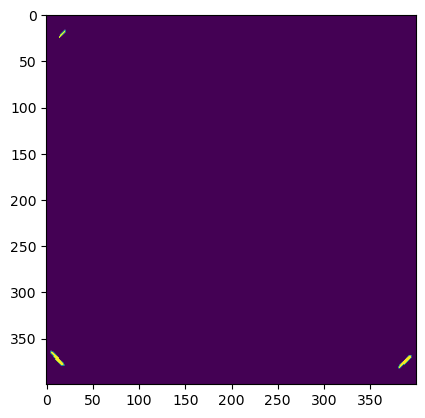

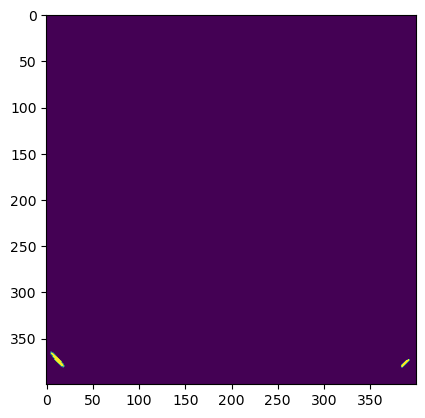

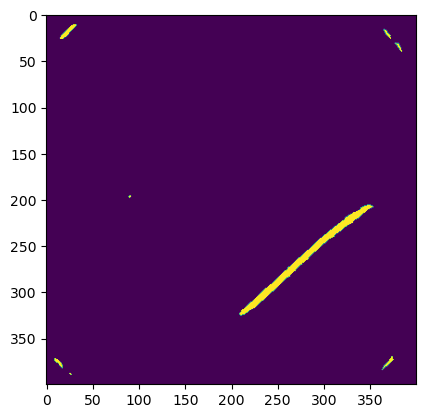

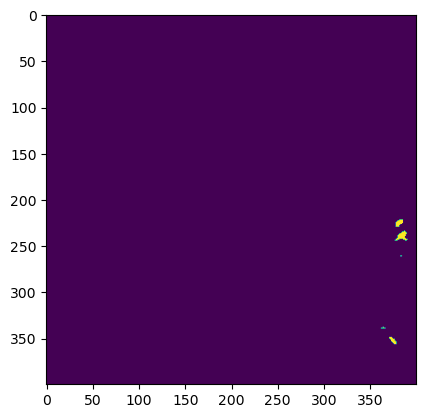

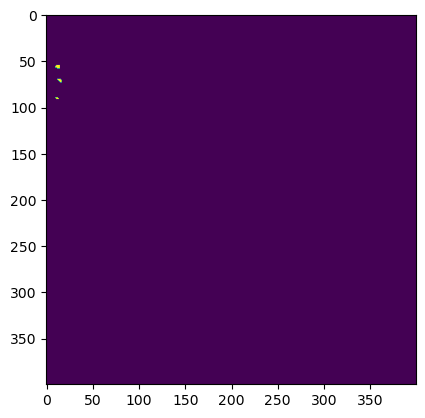

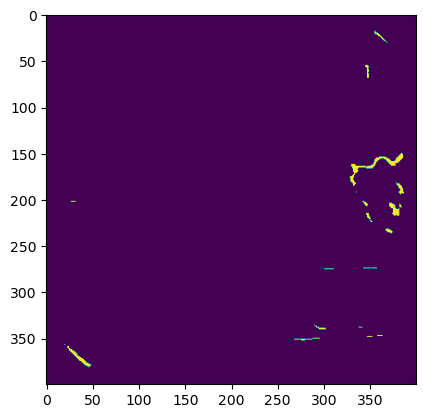

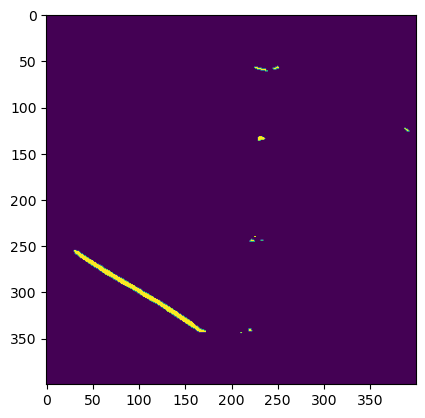

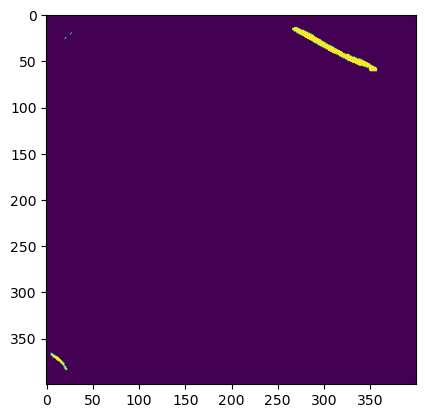

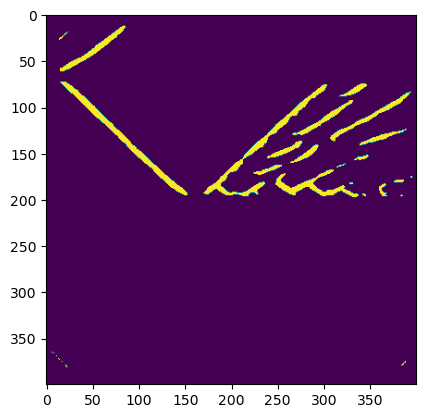

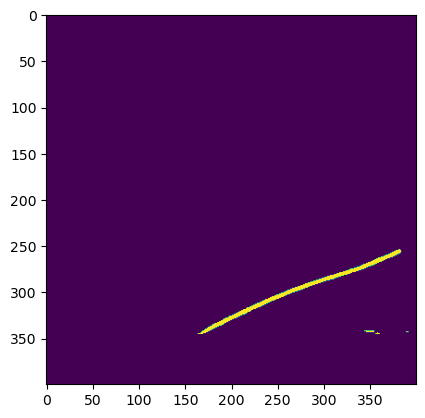

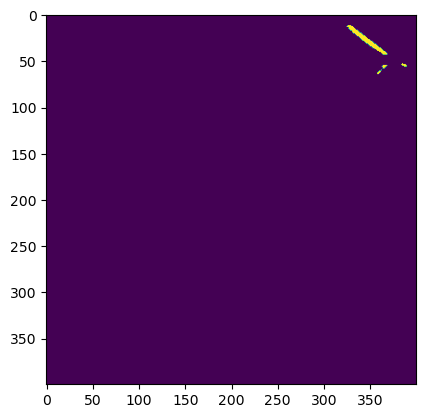

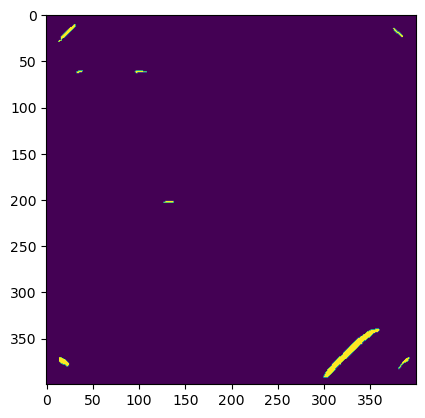

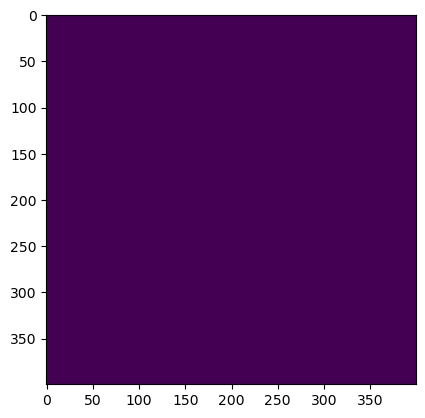

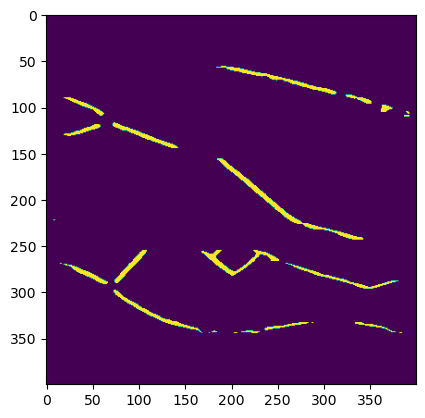

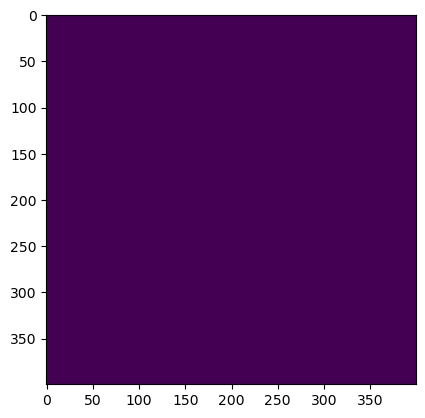

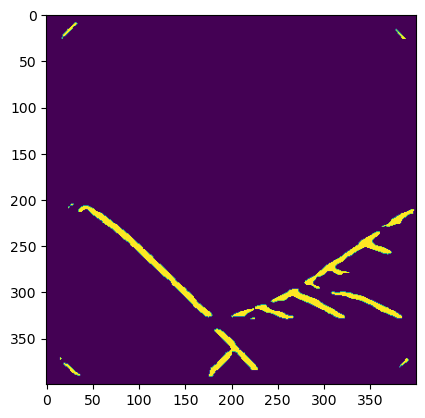

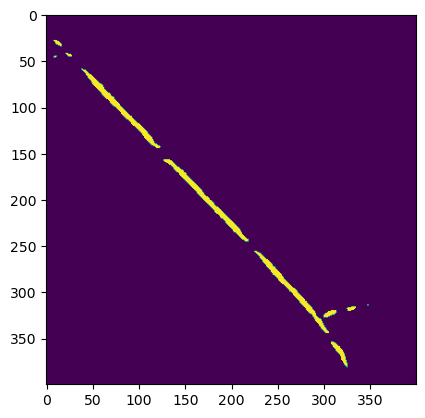

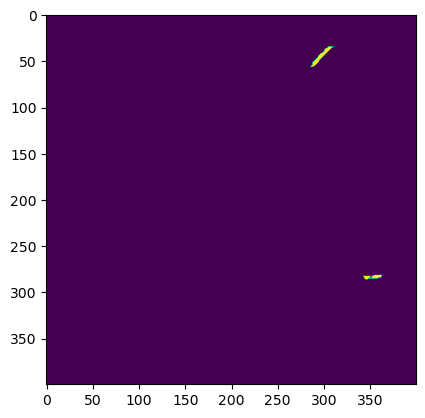

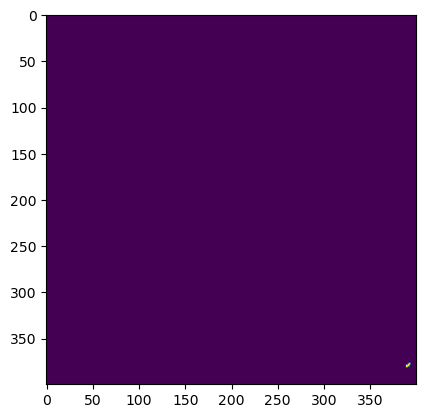

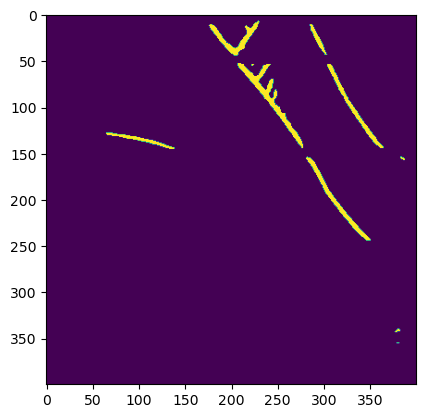

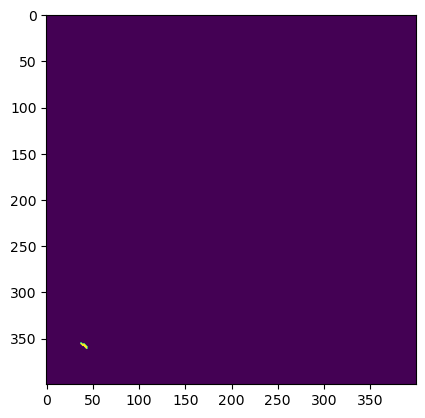

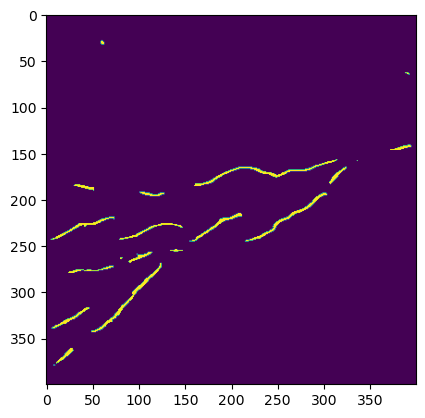

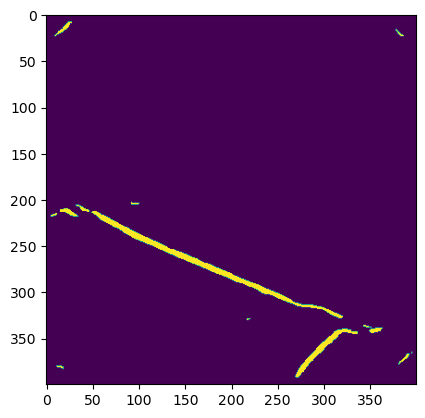

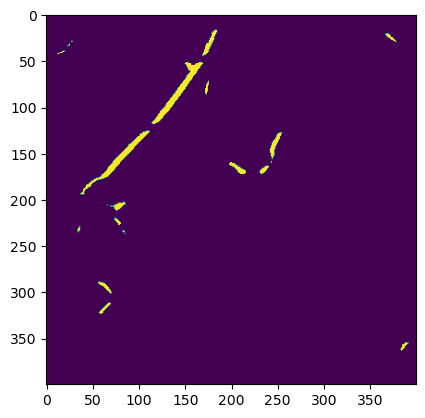

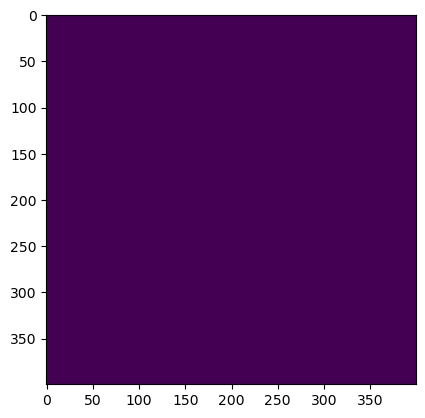

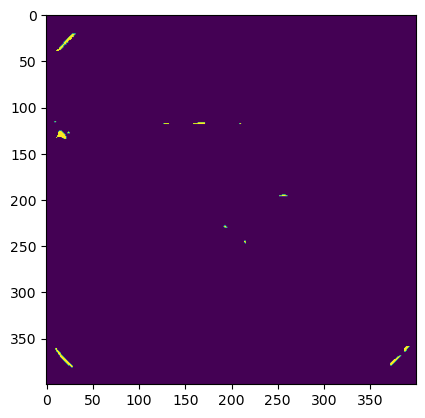

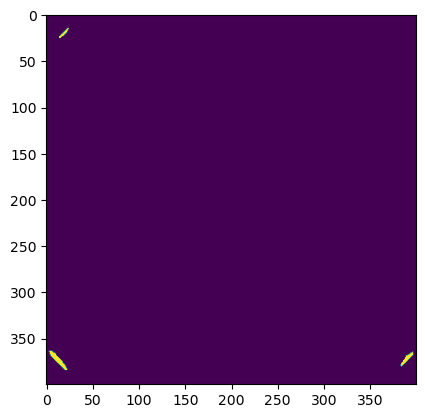

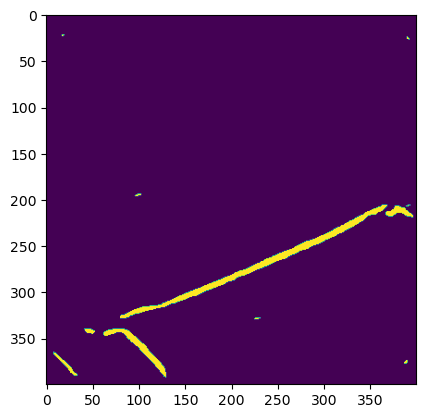

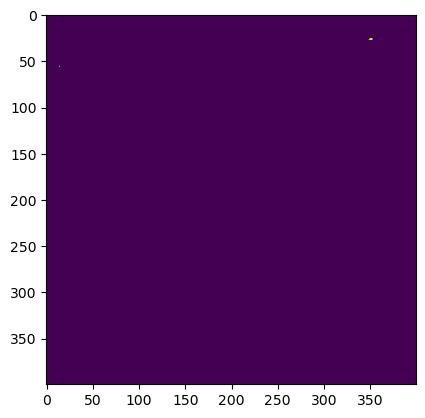

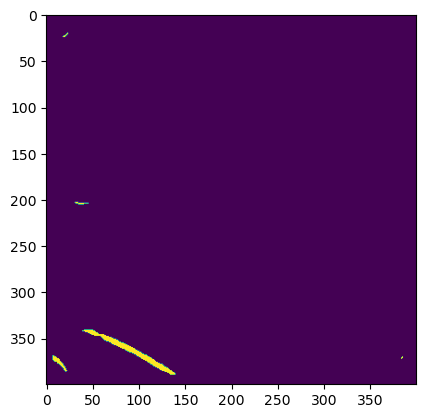

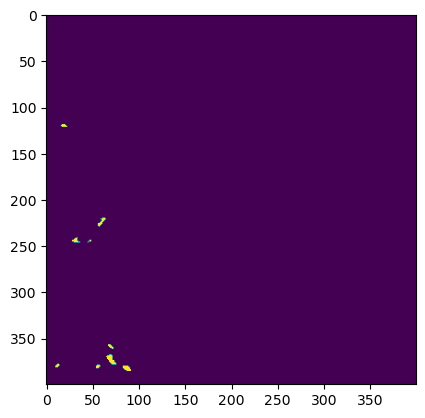

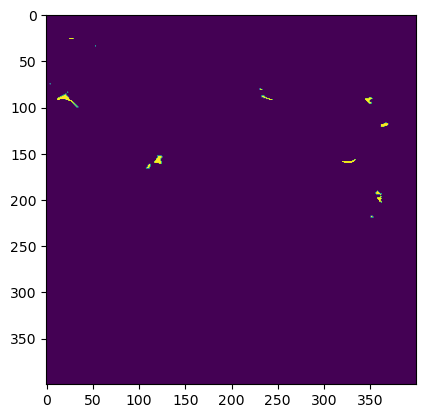

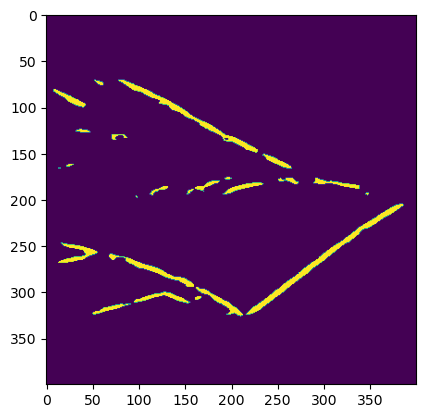

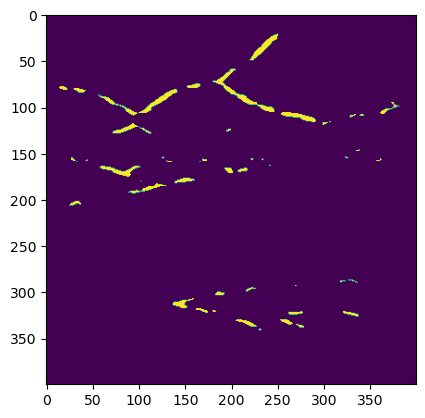

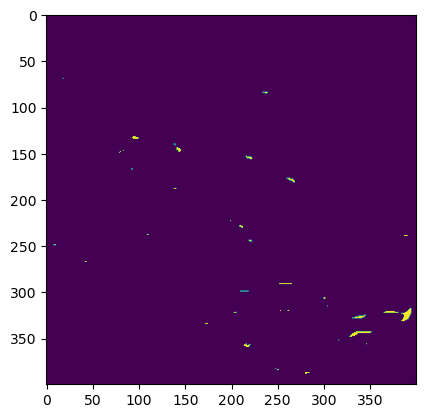

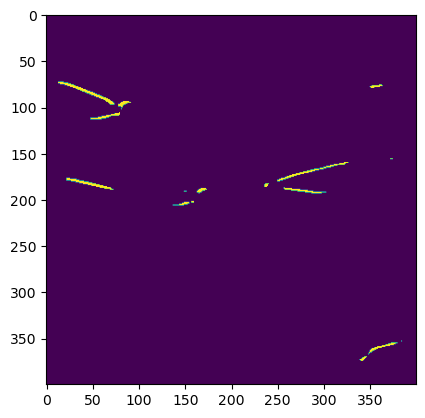

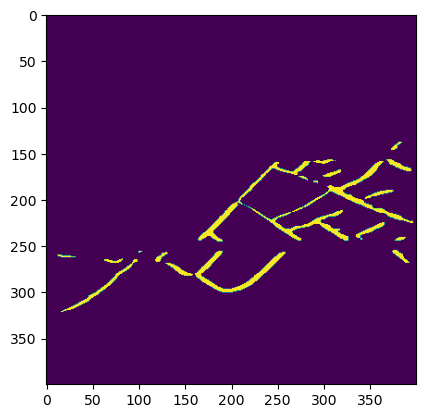

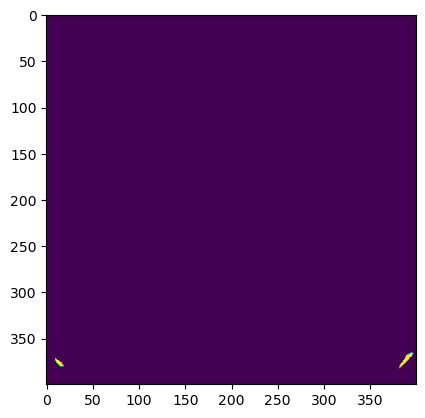

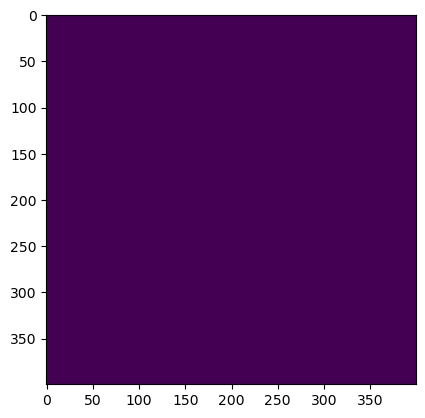

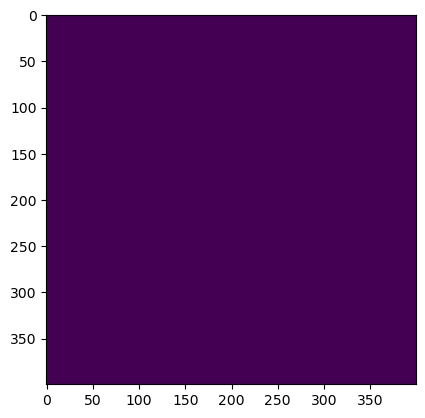

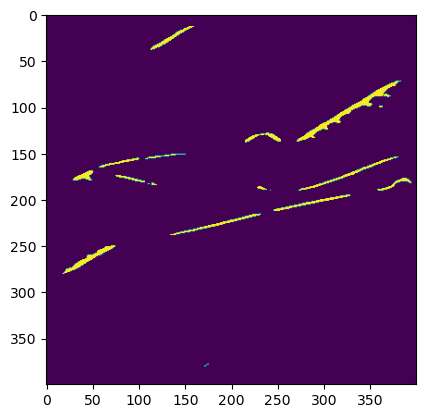

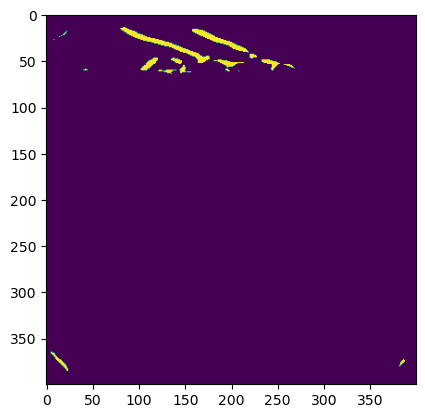

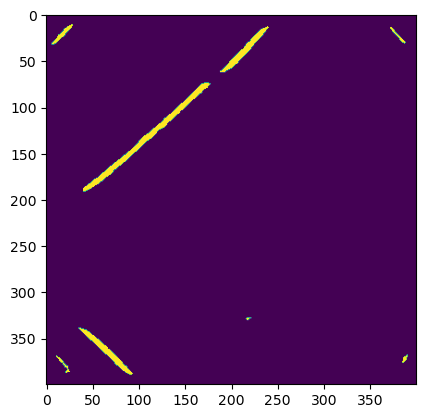

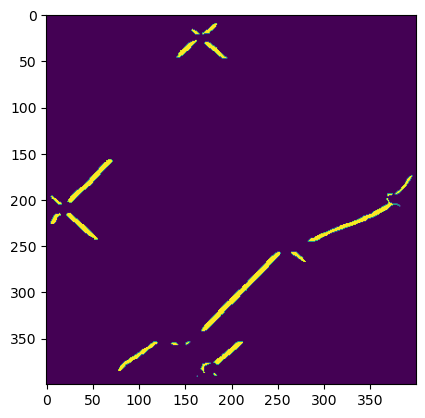

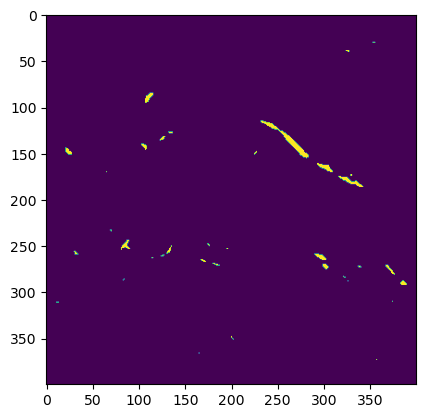

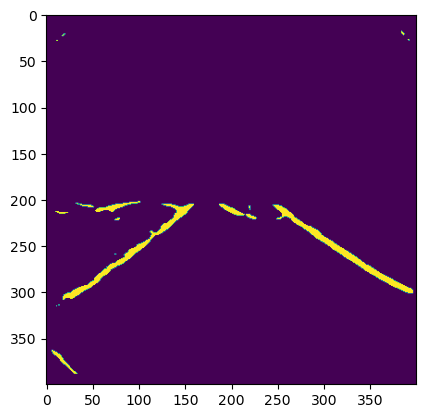

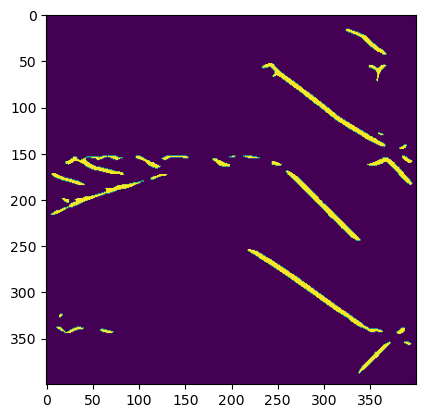

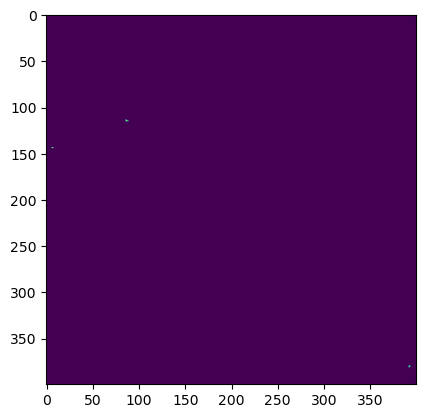

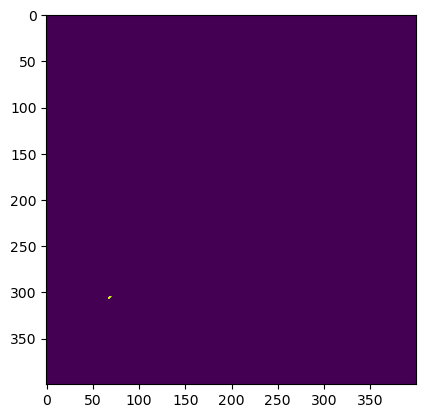

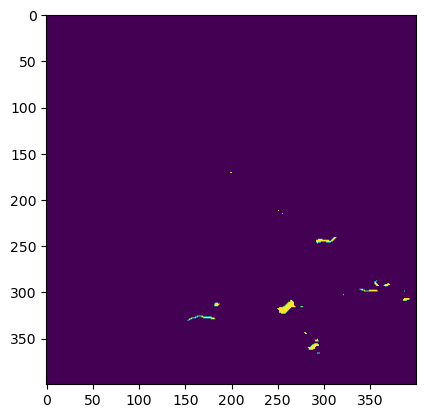

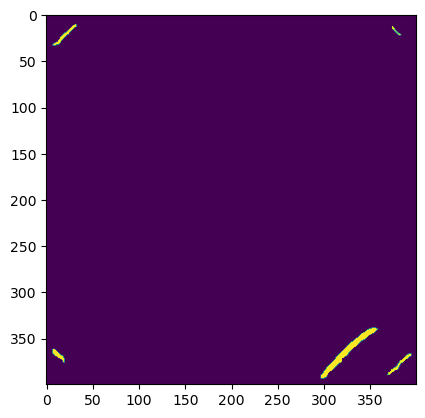

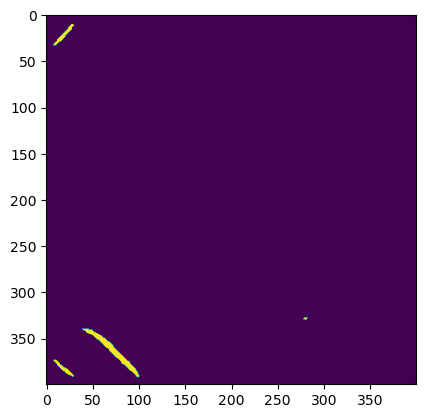

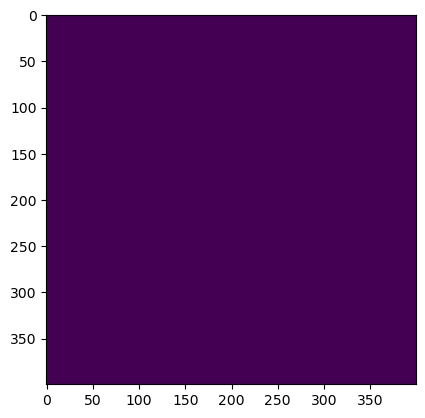

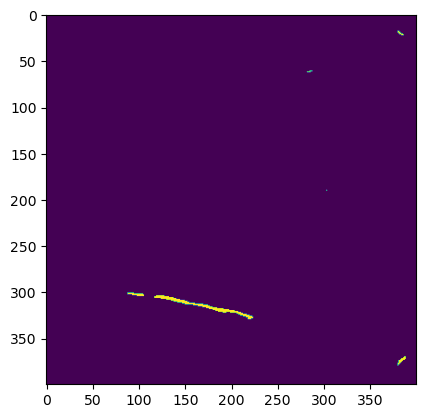

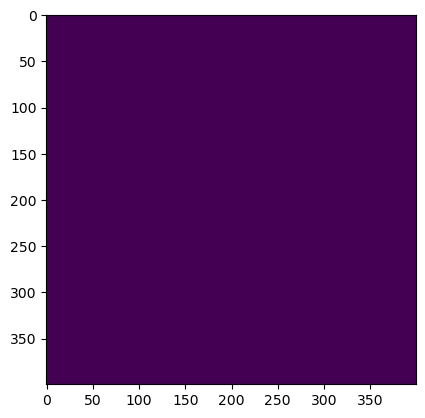

In [11]:
for image in testimg:
    plt.figure()
    plt.imshow(image)

Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.S

/home/nrjost/.conda/envs/pyhpc1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/nrjost/.conda/envs/pyhpc1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


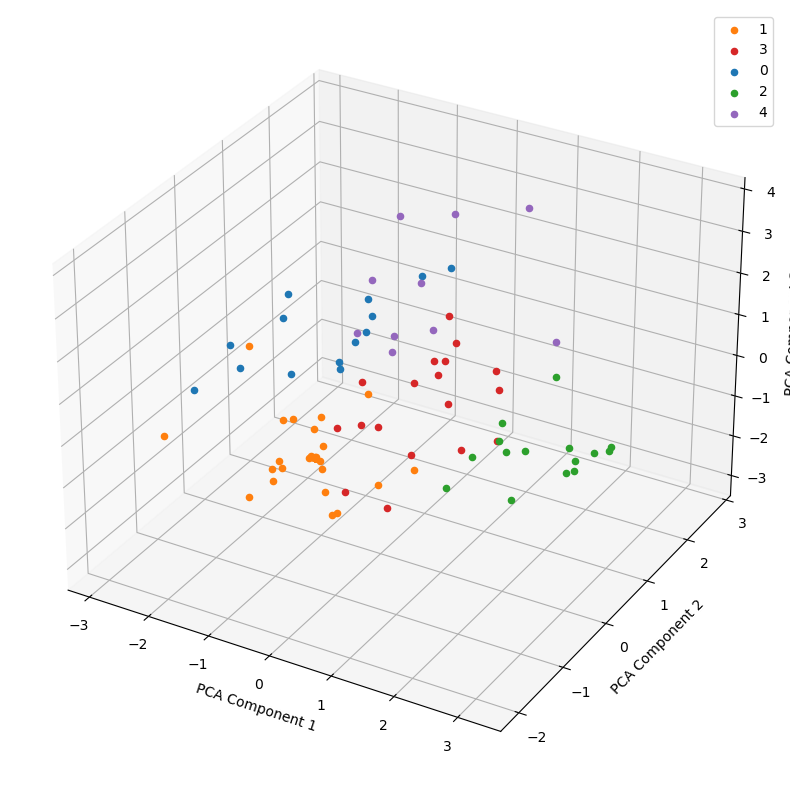

In [12]:
#Plot the latent space, using PCA and k-means

import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pickle
import os.path

# all_z = np.concatenate([z for z in test_loader], axis = 0)
model.eval()

for i, x in enumerate(test_loader):
    z, y = model.encoder(x.to(device))

input_data = x
# batch_size = 262
# input_data = torch.randn(batch_size, 1, 400, 400)

with torch.no_grad():
    latent_spaces, _ = model.encoder(input_data.cuda()) #this would be x from test_loader

data_reshape = latent_spaces.squeeze().cpu().numpy()

pca = PCA(n_components=3)

#generate data_reduce or load to save time
data_reduced = pca.fit_transform(data_reshape)
with open('PCAdata.pickle', 'wb') as handle:
    pickle.dump(data_reduced, handle, protocol=pickle.HIGHEST_PROTOCOL)

if os.path.isfile('./PCAdata.pickle'):
    with open('PCAdata.pickle', 'rb') as handle:
        data_reduced = pickle.load(handle)

kmean = KMeans(n_clusters=5)
kmeans = kmean.fit(data_reduced)
centroids = kmeans.cluster_centers_

#generate klabels or load them to svae time
klabels = kmean.fit_predict(data_reduced)
with open('Kmeandata.pickle', 'wb') as handle:
    pickle.dump(klabels, handle, protocol=pickle.HIGHEST_PROTOCOL)

# if os.path.isfile('./Kmeandata.pickle'):
    # with open('Kmeandata.pickle', 'rb') as handle:
        # klabels = pickle.load(handle)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(data_reduced.shape[0]):
    ax.scatter(data_reduced[i, 0], data_reduced[i, 1], data_reduced[i, 2], c=f'C{klabels[i]}', marker='o', label=klabels[i])

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels
unique_labels = {}

# Iterate through handles and labels
for handle, label in zip(handles, labels):
    # Use only the first occurrence of each label
    if label not in unique_labels:
        unique_labels[label] = handle

# Create a legend with unique labels
ax.legend(unique_labels.values(), unique_labels.keys())

fig.savefig('3Dlatentspace.png')

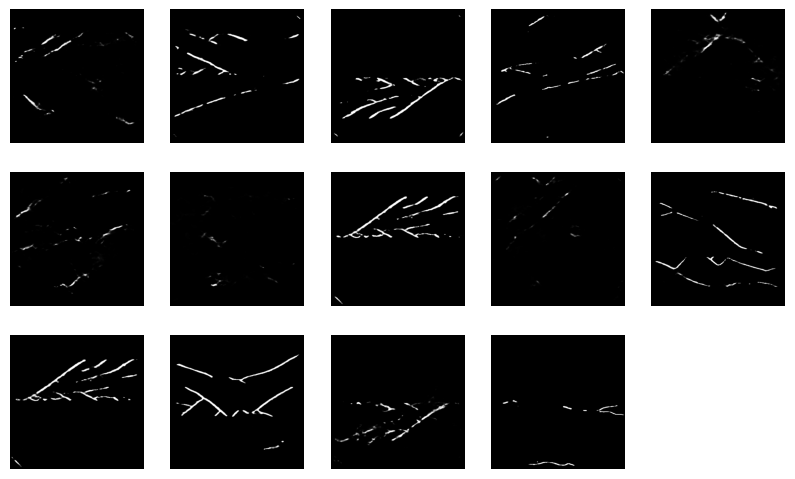

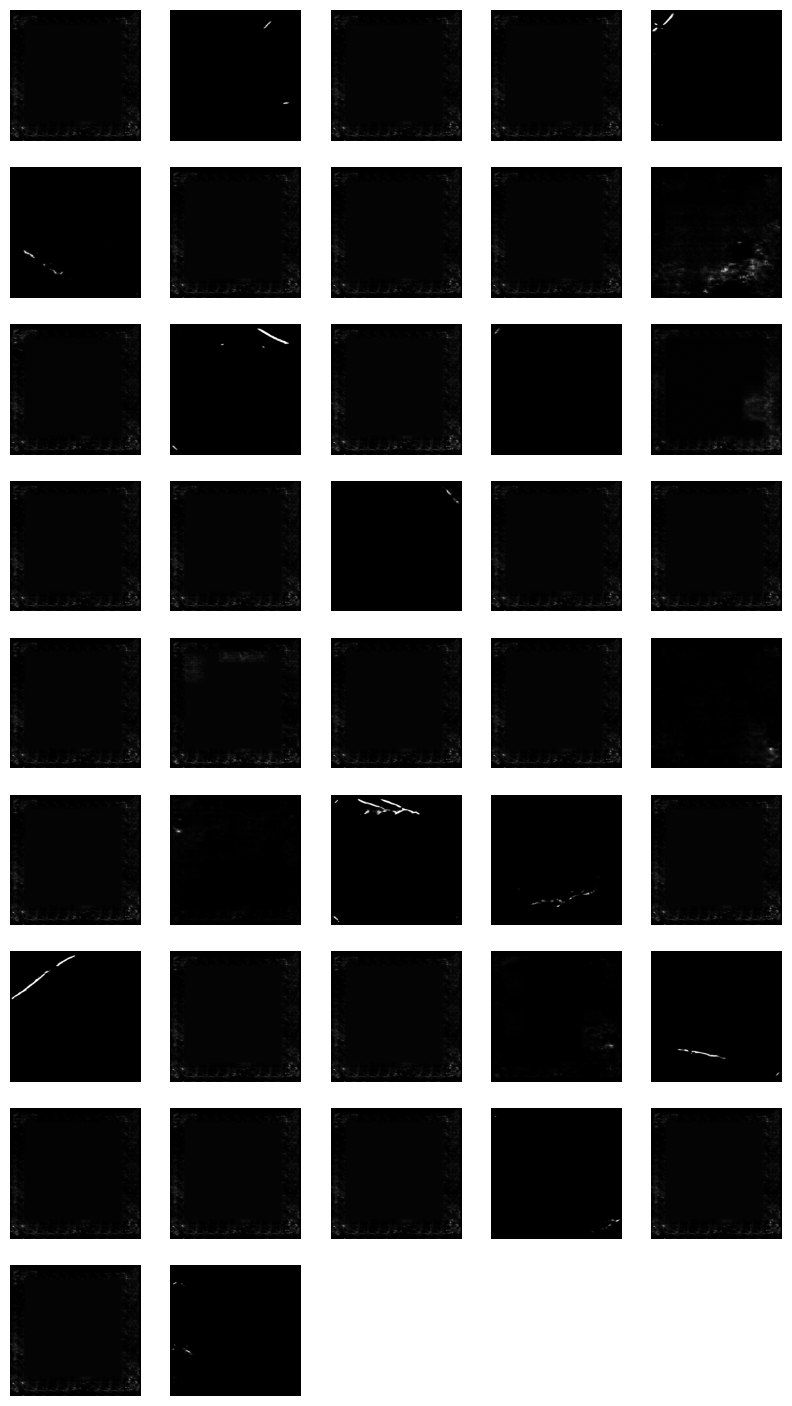

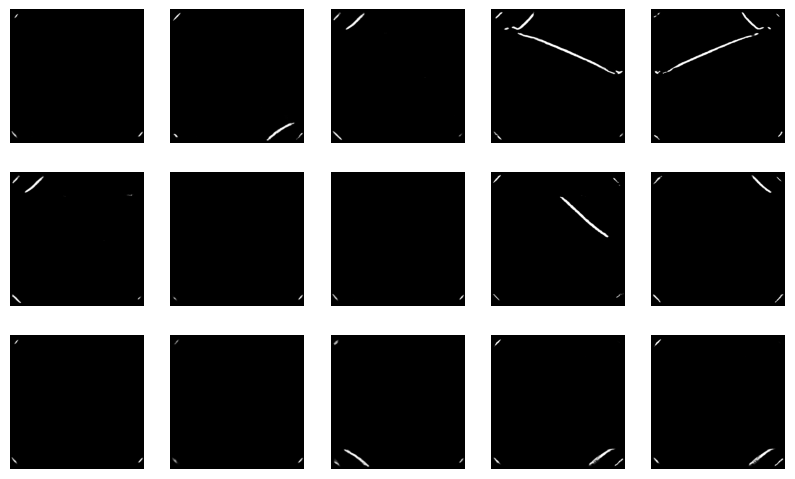

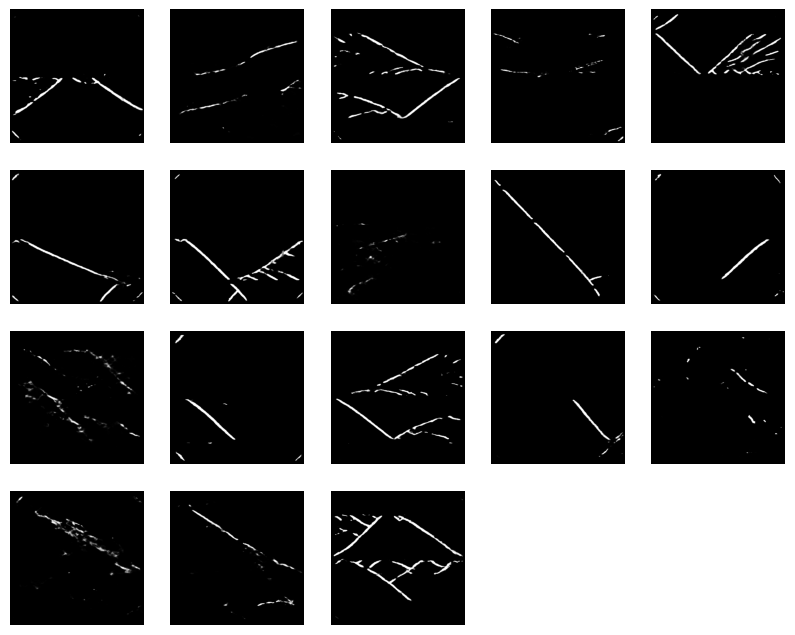

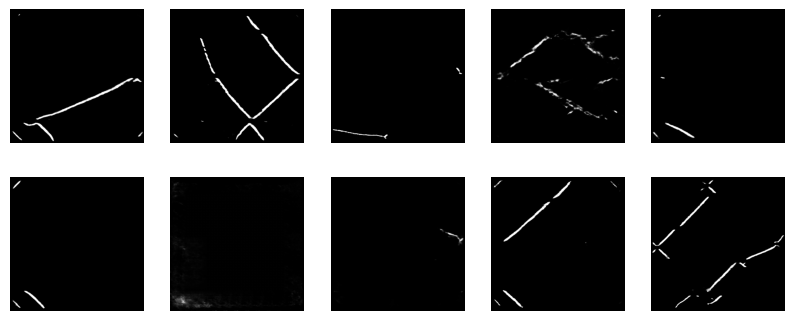

In [13]:
#Showing images in each cluster
import os
path = os.getcwd()
def show_cluster_images(data, label, path, device):
    nspace = data.query('k_label == '+str(label)+'')
    nspace_vectors = nspace['latent_vectors'].tolist()
    nspace_tensors = torch.tensor(nspace_vectors).to(device)
    generated_images = model.decoder(nspace_tensors)
    fig = show_generated_images(generated_images, len(generated_images), path)
    return fig, generated_images, nspace_vectors
    

#Generate images of latent vectors for each cluster to see whats up with them
lspace = pd.DataFrame({'latent_vectors' : data_reshape.tolist(), 'k_label' : klabels})

#sort for each label and geenrate images
fig, cluster0images, cluster0vectors = show_cluster_images(lspace, 0, path, device)
fig2, cluster1images, cluster1vectors = show_cluster_images(lspace, 1, path, device)
fig3, cluster2images, cluster2vectors = show_cluster_images(lspace, 2, path, device)
fig4, cluster3images, cluster3vectors = show_cluster_images(lspace, 3, path, device)
fig5, cluster4images, cluster4vectors = show_cluster_images(lspace, 4, path, device)
# fig6, cluster0images = show_cluster_images(lspace, 5, device)
# fig7, cluster1images = show_cluster_images(lspace, 6, device)
# fig8, cluster2images = show_cluster_images(lspace, 7, device)
# fig9, cluster3images = show_cluster_images(lspace, 8, device)
# fig10, cluster4images = show_cluster_images(lspace, 9, device)


In [14]:
#t-test for features, test every cluster
def ttest_features(data_in, data_out):
    from scipy.stats import ttest_ind
    #Run on detected features from the dataframe
    columns_of_interest = [' prop.perimeter', ' slope', ' prop.convex_area', ' prop.area',
           ' prop.orientation']
    
    # Extract the data from the dataframes
    data1 = data_in[columns_of_interest].apply(pd.to_numeric, errors='coerce')
    data1 = data1.values
    data2 = data_out[columns_of_interest].apply(pd.to_numeric, errors='coerce')
    data2 = data2.values
    
    # Perform independent two-sample t-test for each column
    t_stats = []
    p_values = []
    
    for col in range(data1.shape[1]):
        t_stat, p_value = ttest_ind(data1[:, col], data2[:, col])
        t_stats.append(t_stat)
        p_values.append(p_value)

    pmean = np.mean(p_values)
    tmean = np.mean(t_stats)

    # Display results
    for col, t_stat, p_value in zip(columns_of_interest, t_stats, p_values):
        print(f"Column: {col}, t-statistic: {t_stat.round(5)}, p-value: {p_value.round(5)}")
    print(f"Mean t-stats = {tmean.round(5)}, mean p-values = {pmean.round(5)}")

dic_image_klabel = {'k_label' : klabels, 'input_image' : testimgs}

    
#cluster 0
print("Cluster 0 features t-test")
output = cluster0images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 1
print("Cluster 1 features t-test")
output = cluster1images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 2
print("Cluster 2 features t-test")
output = cluster2images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 3
print("Cluster 3 features t-test")
output = cluster3images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 4
print("Cluster 4 features t-test")
output = cluster4images.to('cpu').detach().numpy() 
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

Cluster 0 features t-test
Column:  prop.perimeter, t-statistic: 4.09072, p-value: 7e-05
Column:  slope, t-statistic: 1.81307, p-value: 0.07211
Column:  prop.convex_area, t-statistic: 3.8621, p-value: 0.00018
Column:  prop.area, t-statistic: 4.43325, p-value: 2e-05
Column:  prop.orientation, t-statistic: 1.30097, p-value: 0.19555
Mean t-stats = 3.10002, mean p-values = 0.05359
Cluster 1 features t-test
Column:  prop.perimeter, t-statistic: -4.35052, p-value: 3e-05
Column:  slope, t-statistic: -1.45637, p-value: 0.14761
Column:  prop.convex_area, t-statistic: -4.84463, p-value: 0.0
Column:  prop.area, t-statistic: -4.58897, p-value: 1e-05
Column:  prop.orientation, t-statistic: 1.50286, p-value: 0.13521
Mean t-stats = -2.74753, mean p-values = 0.05657
Cluster 2 features t-test
Column:  prop.perimeter, t-statistic: 2.99334, p-value: 0.00371
Column:  slope, t-statistic: 3.2417, p-value: 0.00176
Column:  prop.convex_area, t-statistic: 2.61568, p-value: 0.01071
Column:  prop.area, t-statisti

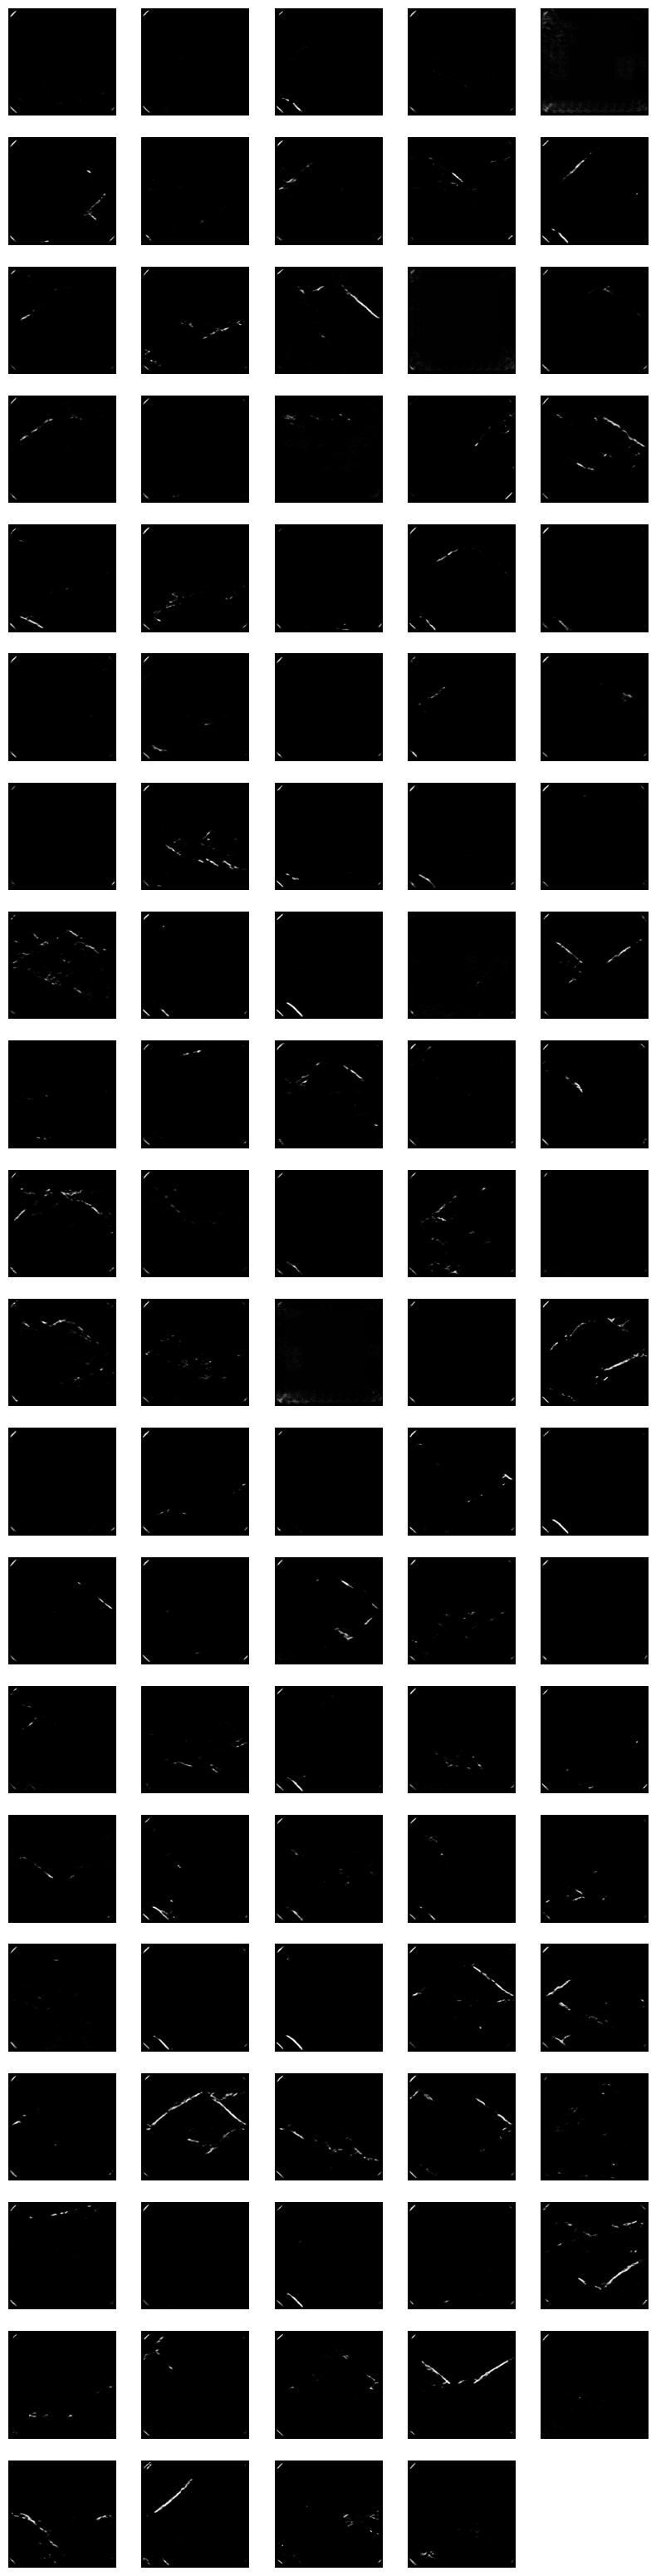

In [23]:
#which cluster wins??? 3
#create latent vectors similar to winning cluster
import random
clustered_latent_vectors = cluster3vectors  # Your clustered latent vectors here

# Calculate the mean vector of the selected vectors or use centroid from k-means
# mean_vector = np.max(clustered_latent_vectors, axis=0)
mean_vector = pca.inverse_transform(centroids[2]) #from 3 dimensions to 50 using PCA

# Create 262 new vectors
num_new_vectors = 99
new_latent_vectors = []

for _ in range(num_new_vectors):
    original_latent_vectors = np.array(clustered_latent_vectors)
    
    # Randomly choose a vector from the original set
    original_vector = original_latent_vectors[random.randint(0, len(original_latent_vectors)-1)]

    # Calculate the difference between the chosen vector and the mean
    diff = original_vector - mean_vector

    # Add or subtract this difference to create a new vector
    top_bot = 1 #spread of new vector in latent space
    new_vector = mean_vector + np.random.uniform(-top_bot, +top_bot, 50) * diff
    # new_vector = mean_vector + top_bot * diff

    # Append the new vector to the list
    new_latent_vectors.append(new_vector)

# Convert the result to a NumPy array
new_latent_vectors = np.array(new_latent_vectors)
new_latent_vectors_list = new_latent_vectors.tolist() #include this otherwise you get type error

#convert to tensors
generated_latent_tensors = torch.tensor(new_latent_vectors_list)
generated_images = model.decoder(generated_latent_tensors.to(device))
fig = show_generated_images(generated_images, len(generated_images), path)


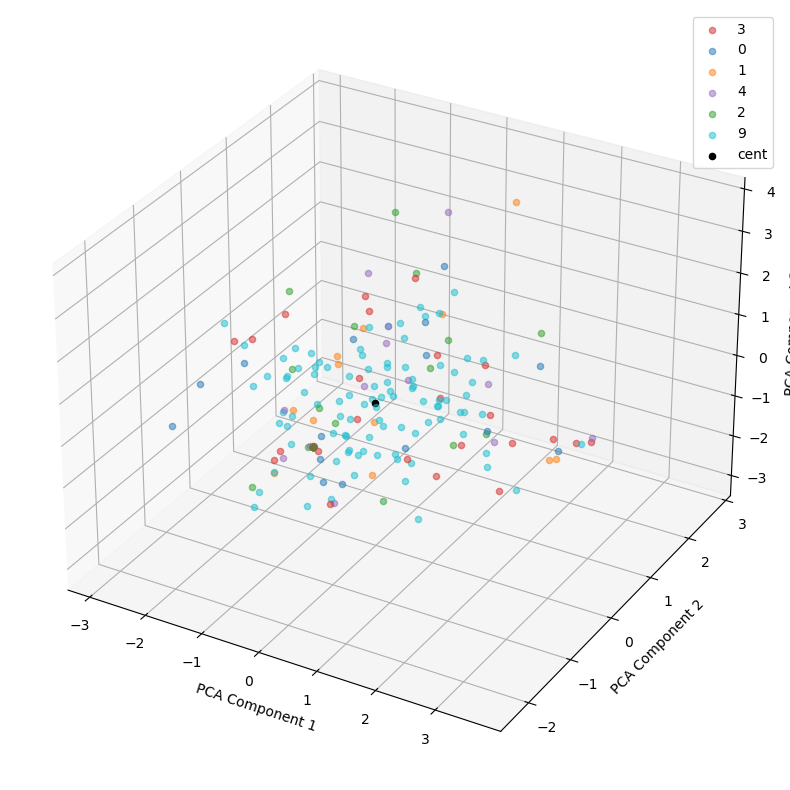

In [24]:
#add generated latent vectors to latent space plot, first approach, cyan (cluster 9 are generated)
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


#add generated latent vectors to the latent space plot
data_reduced = data_reduced
pca = PCA(n_components=3)
new_latent_vectors_reduced = pca.fit_transform(new_latent_vectors)
data_reduced_new = np.concatenate([data_reduced, new_latent_vectors_reduced])
klabels_generated = np.full((new_latent_vectors.shape[0],),9)

klabels = klabels
klabels_new = np.concatenate([klabels, klabels_generated])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(data_reduced_new.shape[0]):
    ax.scatter(data_reduced_new[i, 0], data_reduced_new[i, 1], data_reduced_new[i, 2], c=f'C{klabels_new[i]}', marker='o', label=klabels_new[i], alpha=0.5)

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

#Plot a centroid
centroid = np.mean(new_latent_vectors_reduced, axis=0)
ax.scatter(centroid[0], centroid[1], centroid[2], c='black', marker='o', label='cent', alpha=1)


# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels
unique_labels = {}

# Iterate through handles and labels
for handle, label in zip(handles, labels):
    # Use only the first occurrence of each label
    if label not in unique_labels:
        unique_labels[label] = handle

# Create a legend with unique labels
ax.legend(unique_labels.values(), unique_labels.keys())

# fig.savefig('3Dlatentspace.png')

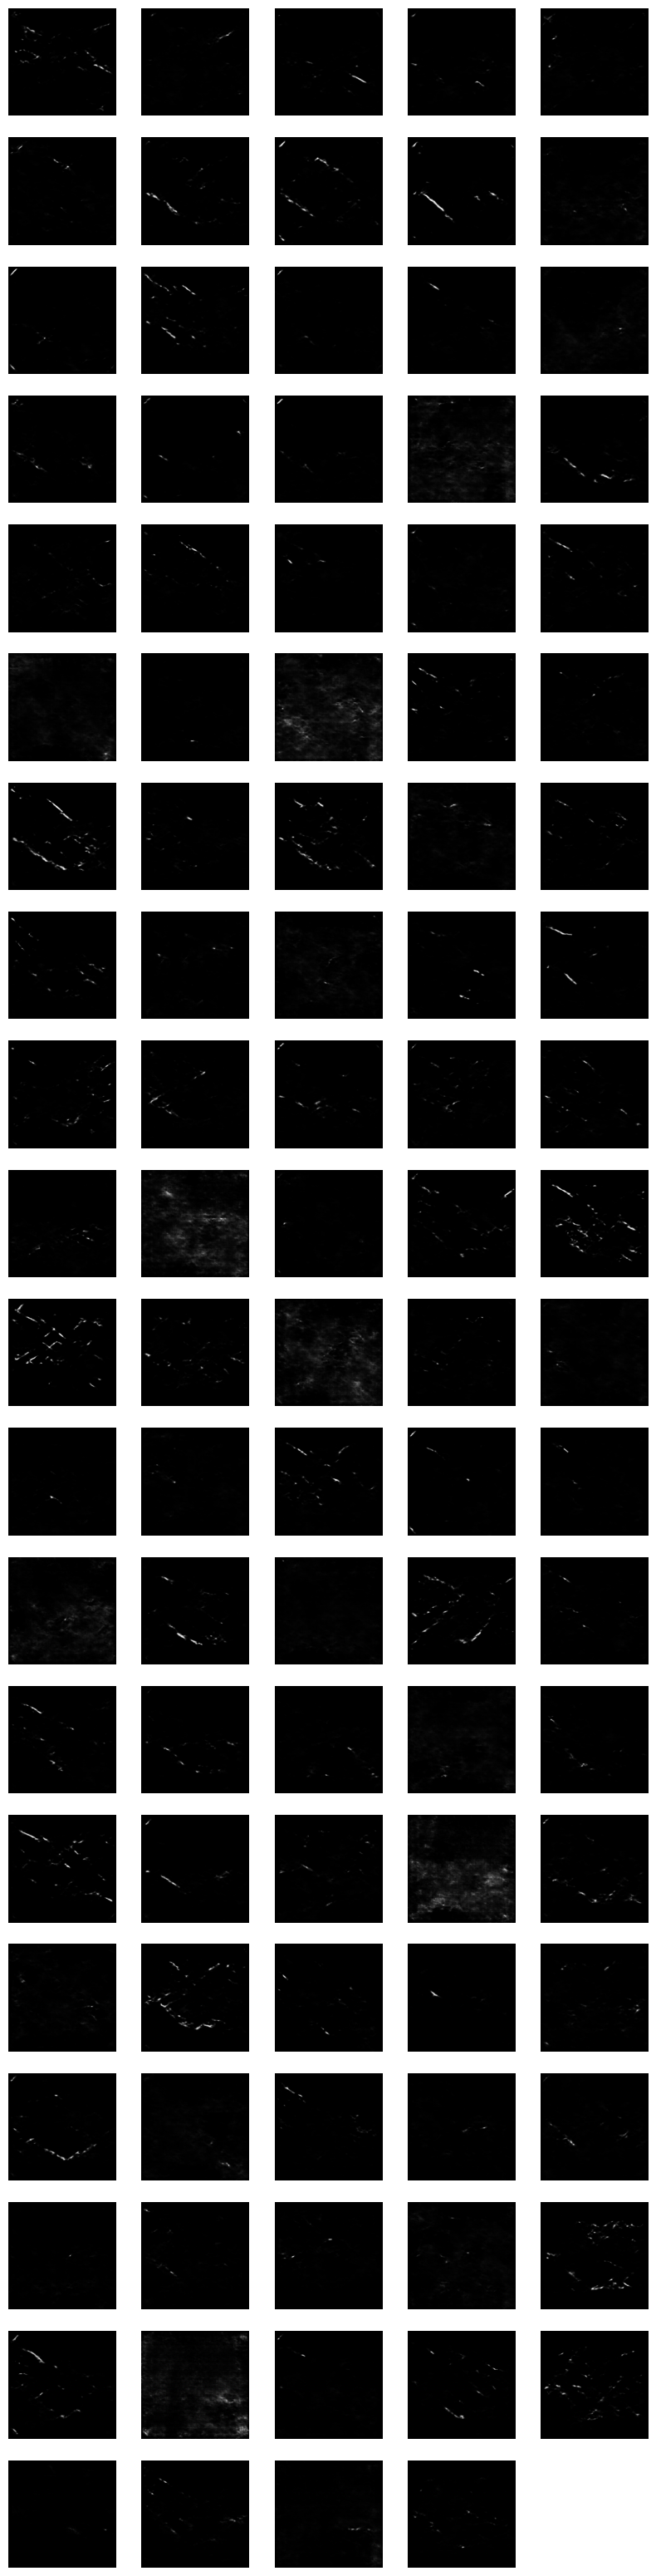

In [25]:
#Another appraoch for creating new latent vector similar to cluster

# Assuming `original_cluster` is your existing cluster
original_cluster = cluster3vectors

# Calculate mean for the original cluster
mean_original = np.mean(original_cluster, axis=0)

# Adjust the scaling factor to control the spread
scaling_factor = 0.2 

# Number of additional samples you want
num_additional_samples = 99

# Generate new samples using a multivariate normal distribution with the scaled identity matrix 
new_samples = np.random.multivariate_normal(mean_original, np.eye(50)*scaling_factor, size=num_additional_samples)

# Ensure no repetition by removing duplicates
new_latent_vectors = np.unique(new_samples, axis=0)

new_latent_vectors_list = new_latent_vectors.tolist() #include this otherwise you get type error

#convert to tensors
generated_latent_tensors = torch.tensor(new_latent_vectors_list)
generated_images = model.decoder(generated_latent_tensors.to(device))
fig = show_generated_images(generated_images, len(generated_images), path)


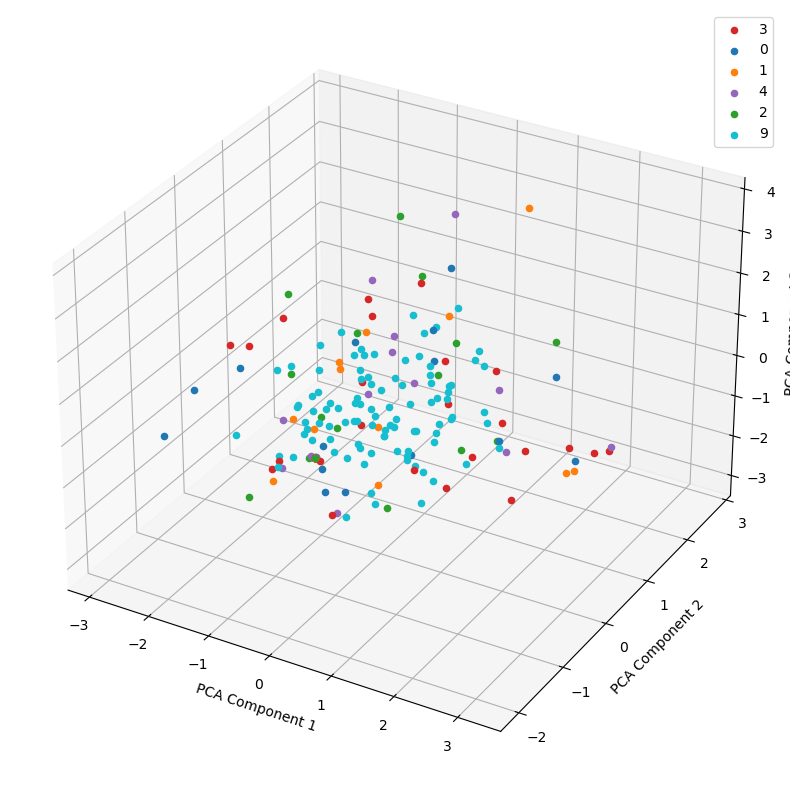

In [26]:
#add generated latent vectors to latent space plot, second approach, cyan (cluster 9 are generated)
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


#add generated

data_reduced = data_reduced
pca = PCA(n_components=3)
new_latent_vectors_reduced = pca.fit_transform(new_latent_vectors)
data_reduced_new = np.concatenate([data_reduced, new_latent_vectors_reduced])
klabels_generated = np.full((new_latent_vectors.shape[0],),9)

klabels = klabels
klabels_new = np.concatenate([klabels, klabels_generated])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(data_reduced_new.shape[0]):
    ax.scatter(data_reduced_new[i, 0], data_reduced_new[i, 1], data_reduced_new[i, 2], c=f'C{klabels_new[i]}', marker='o', label=klabels_new[i])

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels
unique_labels = {}

# Iterate through handles and labels
for handle, label in zip(handles, labels):
    # Use only the first occurrence of each label
    if label not in unique_labels:
        unique_labels[label] = handle

# Create a legend with unique labels
ax.legend(unique_labels.values(), unique_labels.keys())

# fig.savefig('3Dlatentspace.png')

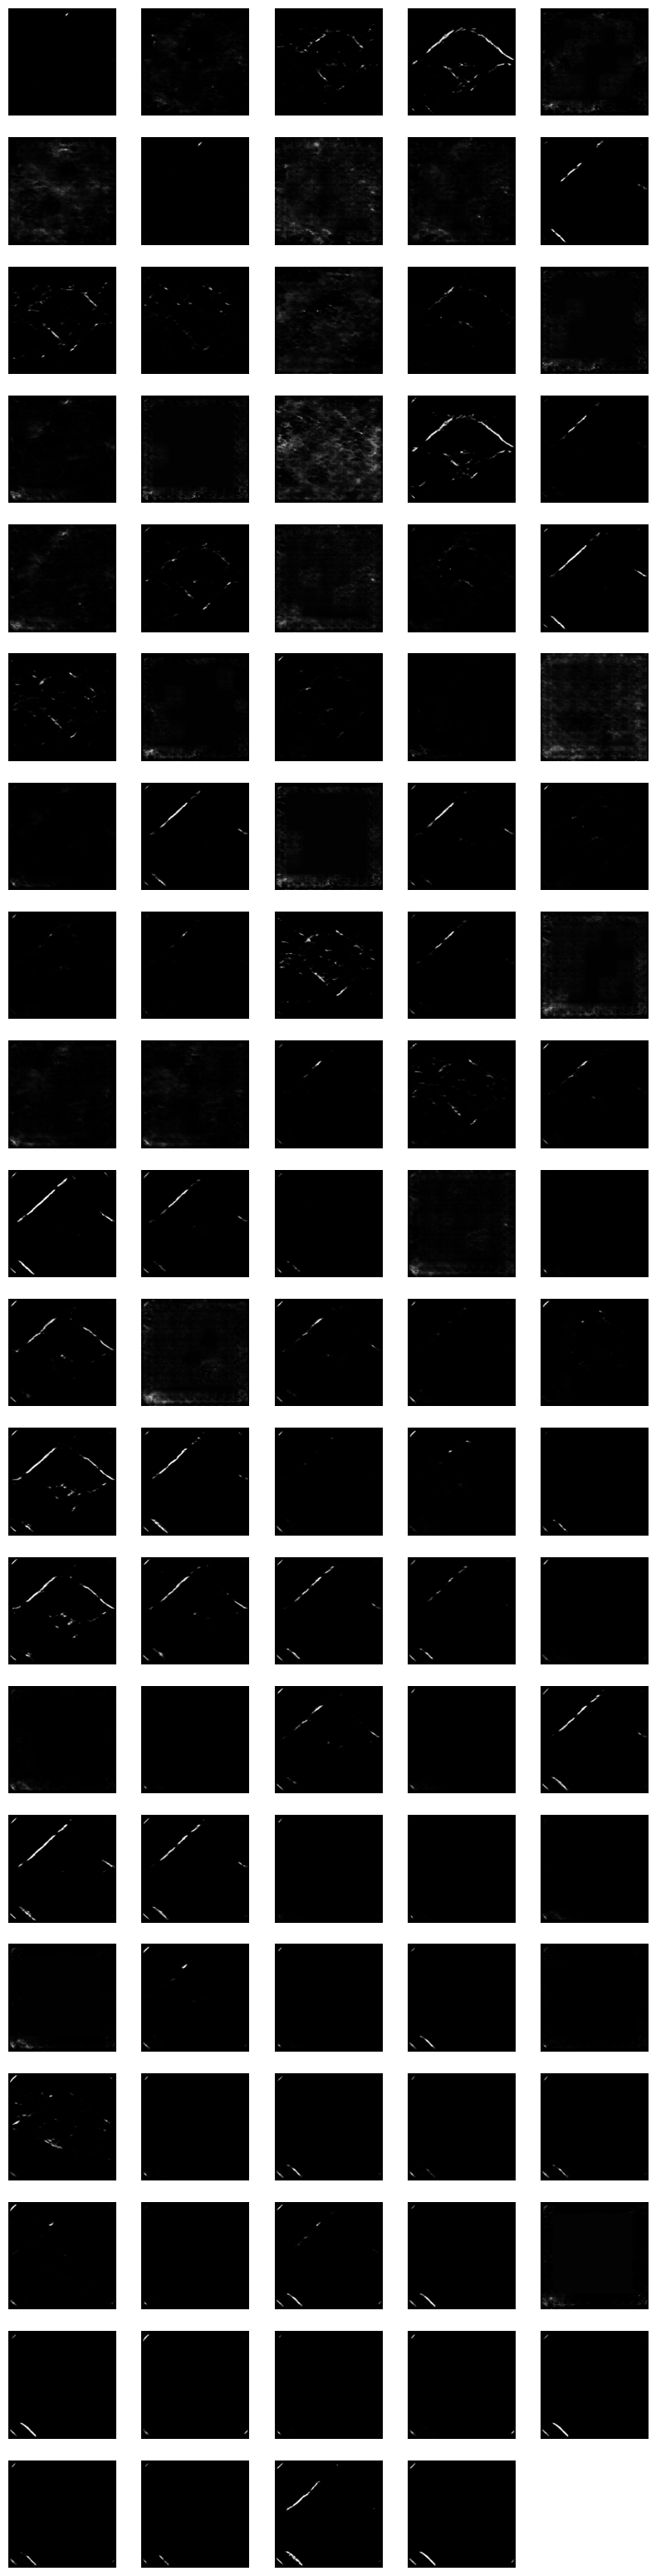

In [19]:
#use k-means cluter_centers for generation
pca = PCA(n_components=3)
data_reduced = pca.fit_transform(data_reshape)

# Identify the cluster of interest
cluster_of_interest = 4
centroid_of_interest = kmeans.cluster_centers_[cluster_of_interest]

# Generate similar vectors using a multivariate normal distribution with an identity matrix and isotropic scaling
num_samples_to_generate = 99
similar_vectors = np.random.multivariate_normal(centroid_of_interest, np.eye(3)*0.9, size=num_samples_to_generate)

# Inverse transform PCA to fo back to 50 sim, is it working?
new_latent_vectors = np.unique(similar_vectors, axis=0)
new_latent_vectors_inv = pca.inverse_transform(new_latent_vectors)

new_latent_vectors_list = new_latent_vectors_inv.tolist() #include this otherwise you get type error
new_latent_vectors_inv
#convert to tensors
generated_latent_tensors = torch.tensor(new_latent_vectors_list)
generated_images = model.decoder(generated_latent_tensors.to(device))
fig = show_generated_images(generated_images, len(generated_images), path)

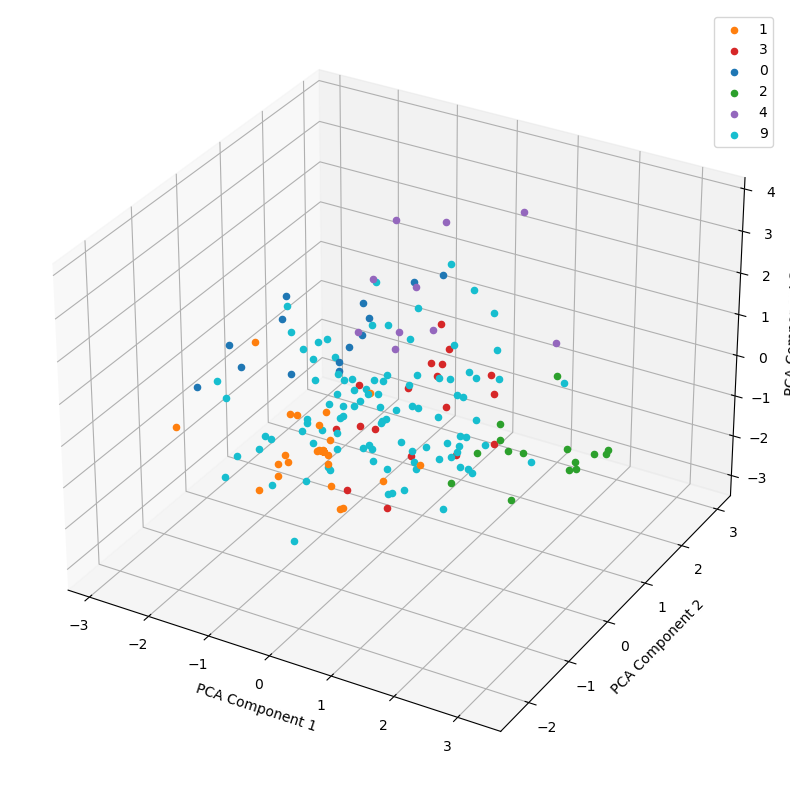

In [20]:
#add generated latent vectors to latent space plot, third approach, cyan (cluster 9 are generated)
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


#add generated

data_reduced = data_reduced
pca = PCA(n_components=3)
new_latent_vectors_reduced = pca.fit_transform(new_latent_vectors_inv)
data_reduced_new = np.concatenate([data_reduced, new_latent_vectors_reduced])
klabels_generated = np.full((new_latent_vectors.shape[0],),9)

klabels = klabels
klabels_new = np.concatenate([klabels, klabels_generated])

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(data_reduced_new.shape[0]):
    ax.scatter(data_reduced_new[i, 0], data_reduced_new[i, 1], data_reduced_new[i, 2], c=f'C{klabels_new[i]}', marker='o', label=klabels_new[i])

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels
unique_labels = {}

# Iterate through handles and labels
for handle, label in zip(handles, labels):
    # Use only the first occurrence of each label
    if label not in unique_labels:
        unique_labels[label] = handle

# Create a legend with unique labels
ax.legend(unique_labels.values(), unique_labels.keys())

# fig.savefig('3Dlatentspace.png')

Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.S

/home/nrjost/.conda/envs/pyhpc1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


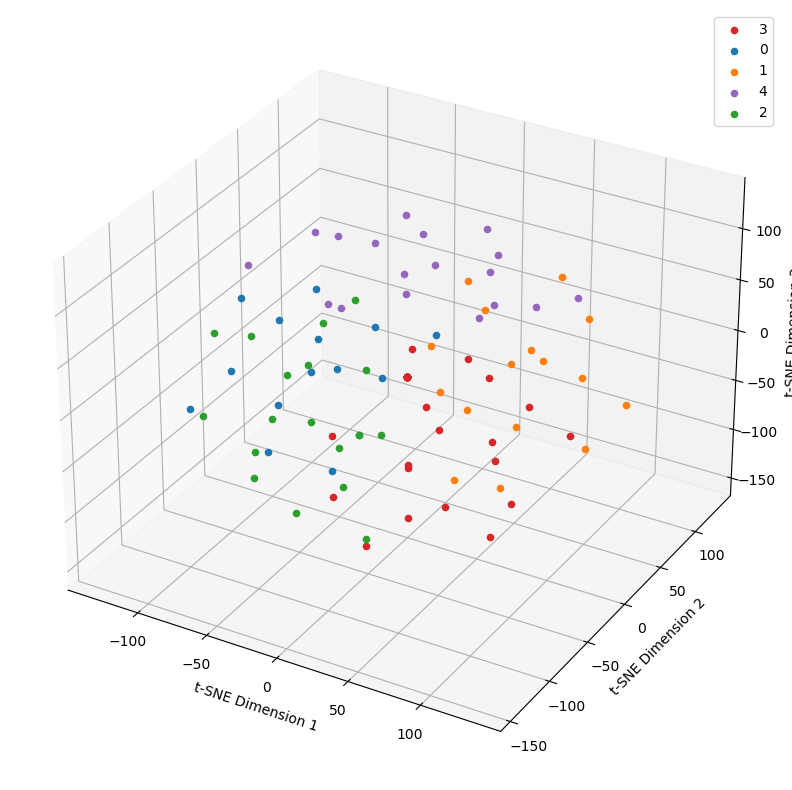

In [21]:
from sklearn.manifold import TSNE

#collect all latent vectors
# all_z = np.concatenate([z for z in test_loader], axis = 0)
for i, x in enumerate(test_loader):
    z, y = model.encoder(x.to(device))

input_data = x
# batch_size = 262
# input_data = torch.randn(batch_size, 1, 400, 400)

with torch.no_grad():
    latent_spaces, _ = model.encoder(input_data.cuda()) #this would be x from test_loader

data_reshape = latent_spaces.squeeze().cpu().numpy()

#apply T-SNE for reduction to 3D
tsne = TSNE(n_components=3, random_state=42)
latent_tsne = tsne.fit_transform(data_reshape)

#k-means
kmean = KMeans(n_clusters=5)
klabels = kmean.fit_predict(latent_tsne)

#plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for i in range(latent_tsne.shape[0]):
    ax.scatter(latent_tsne[i, 0], latent_tsne[i, 1], latent_tsne[i, 2], c=f'C{klabels[i]}', label=klabels[i], marker='o')
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = {}
for handle, label in zip(handles, labels):
    # Use only the first occurrence of each label
    if label not in unique_labels:
        unique_labels[label] = handle
ax.legend(unique_labels.values(), unique_labels.keys())


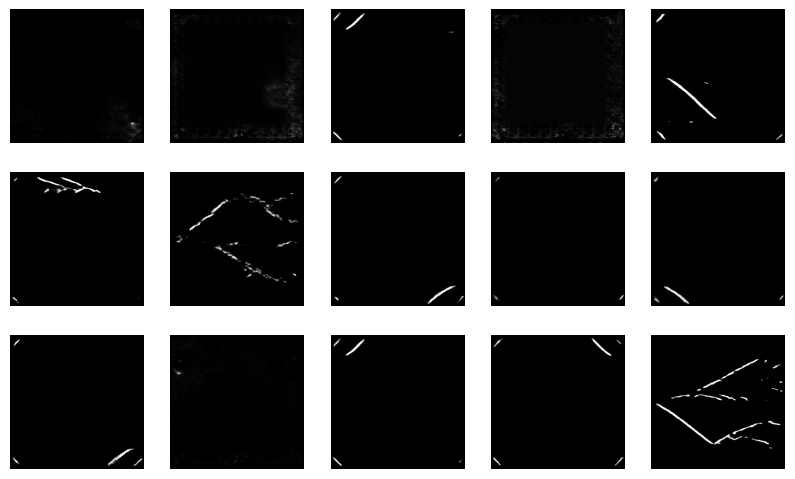

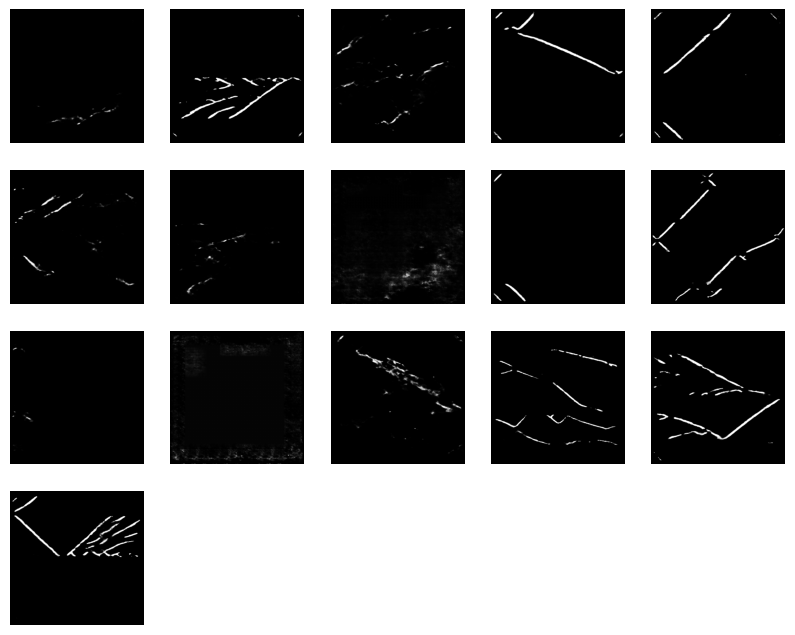

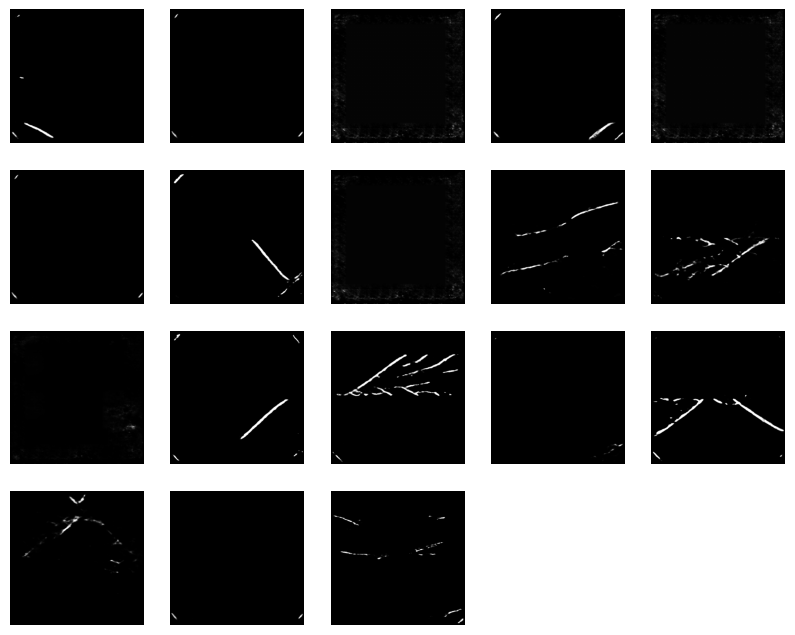

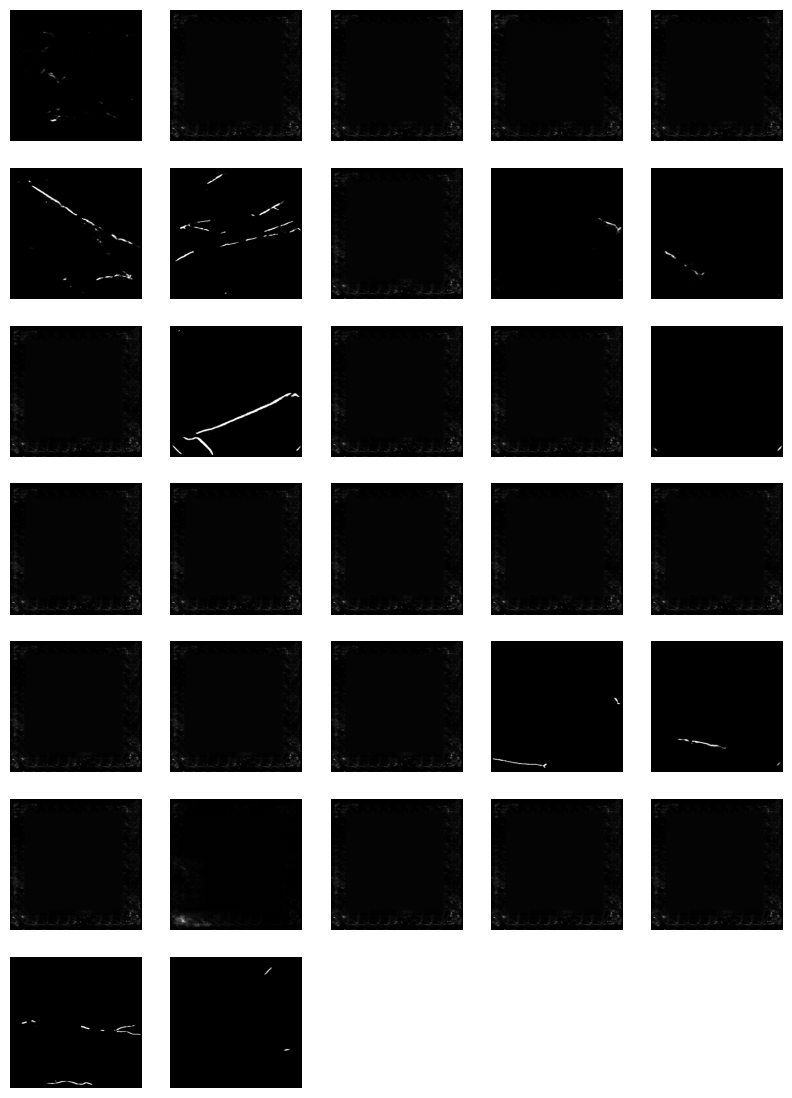

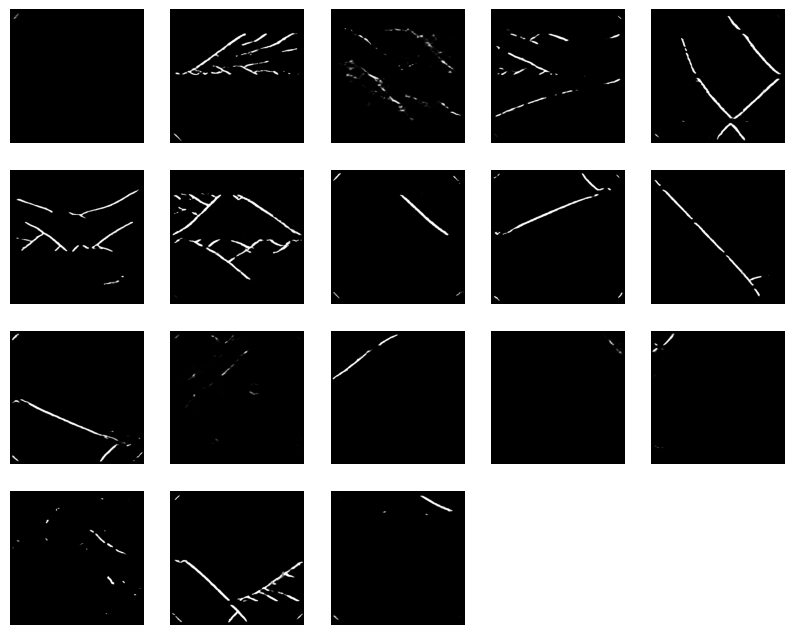

In [29]:
#Show TSNE clusters
#Generate images of latent vectors for each cluster to see whats up with them
lspace = pd.DataFrame({'latent_vectors' : latent_spaces.tolist(), 'k_label' : klabels})

#sort for each label and geenrate images
fig = show_cluster_images(lspace, 0, path, device)
# fig.suptitle(f"Images of label = 0")
fig2 = show_cluster_images(lspace, 1, path, device)
# fig1.suptitle(f"Images of label = 1")
fig3 = show_cluster_images(lspace, 2, path, device)
# fig1.suptitle(f"Images of label = 2")
fig4 = show_cluster_images(lspace, 3, path, device)
# fig1.suptitle(f"Images of label = 3")
fig5 = show_cluster_images(lspace, 4, path, device)
# fig1.suptitle(f"Images of label = 4")



In [30]:
#t-test for features:
#Not better thank using PCA for the dimension reduction
#cluster 0
print("Cluster 0 features t-test")
output = cluster0images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 1
print("Cluster 1 features t-test")
output = cluster1images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 2
print("Cluster 2 features t-test")
output = cluster2images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 3
print("Cluster 3 features t-test")
output = cluster3images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 4
print("Cluster 4 features t-test")
output = cluster4images.to('cpu').detach().numpy() 
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

Cluster 0 features t-test
Column:  prop.perimeter, t-statistic: 4.09072, p-value: 7e-05
Column:  slope, t-statistic: 1.81307, p-value: 0.07211
Column:  prop.convex_area, t-statistic: 3.8621, p-value: 0.00018
Column:  prop.area, t-statistic: 4.43325, p-value: 2e-05
Column:  prop.orientation, t-statistic: 1.30097, p-value: 0.19555
Mean t-stats = 3.10002, mean p-values = 0.05359
Cluster 1 features t-test
Column:  prop.perimeter, t-statistic: -4.35052, p-value: 3e-05
Column:  slope, t-statistic: -1.45637, p-value: 0.14761
Column:  prop.convex_area, t-statistic: -4.84463, p-value: 0.0
Column:  prop.area, t-statistic: -4.58897, p-value: 1e-05
Column:  prop.orientation, t-statistic: 1.50286, p-value: 0.13521
Mean t-stats = -2.74753, mean p-values = 0.05657
Cluster 2 features t-test
Column:  prop.perimeter, t-statistic: 2.99334, p-value: 0.00371
Column:  slope, t-statistic: 3.2417, p-value: 0.00176
Column:  prop.convex_area, t-statistic: 2.61568, p-value: 0.01071
Column:  prop.area, t-statisti

Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.Size([400, 400, 1])
Shape of image after adding channel dimension: torch.Size([1, 400, 400])
Shape of image from data: (400, 400, 1)
Shape of image after conversion to tensor: torch.S

/home/nrjost/.conda/envs/pyhpc1/lib/python3.9/site-packages/hdbscan/plots.py:837: RuntimeWarning: divide by zero encountered in true_divide
  line_width = edge_linewidth * (np.log(self._mst.T[2].max() / self._mst.T[2]) + 1.0)
/home/nrjost/.conda/envs/pyhpc1/lib/python3.9/site-packages/matplotlib/lines.py:66: RuntimeWarning: invalid value encountered in double_scalars
  scaled_offset = offset * lw


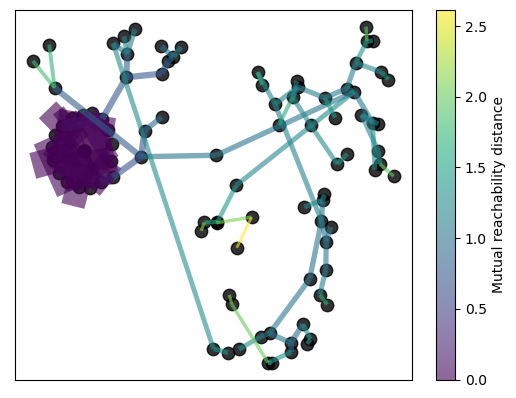

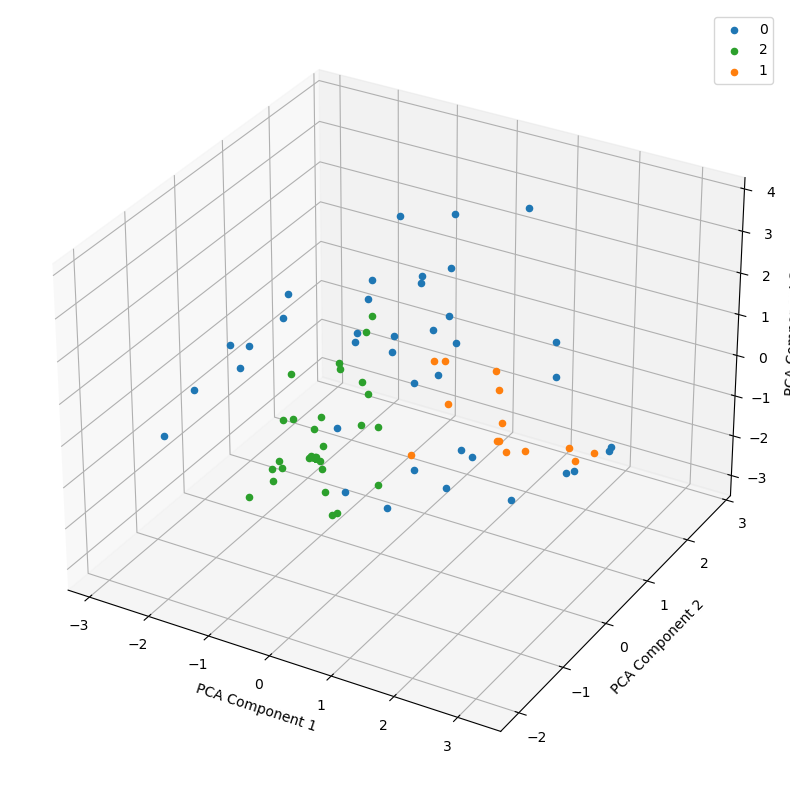

In [31]:
#Cluster with HDBSCAN
#Get HDBSCAN conda install -c conda-forge hdbscan
import hdbscan

# all_z = np.concatenate([z for z in test_loader], axis = 0)
model.eval()

for i, x in enumerate(test_loader):
    z, y = model.encoder(x.to(device))

input_data = x
# batch_size = 262
# input_data = torch.randn(batch_size, 1, 400, 400)

with torch.no_grad():
    latent_spaces, _ = model.encoder(input_data.cuda()) #this would be x from test_loader

data_reshape = latent_spaces.squeeze().cpu().numpy()

pca = PCA(n_components=3)

#generate data_reduce or load to save time
data_reduced = pca.fit_transform(data_reshape)
with open('PCAdata.pickle', 'wb') as handle:
    pickle.dump(data_reduced, handle, protocol=pickle.HIGHEST_PROTOCOL)

if os.path.isfile('./PCAdata.pickle'):
    with open('PCAdata.pickle', 'rb') as handle:
        data_reduced = pickle.load(handle)

# kmean = KMeans(n_clusters=5)
# kmeans = kmean.fit(data_reduced)
# centroids = kmeans.cluster_centers_

clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(data_reduced)

clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)


# #generate labels or load them to svae time
labels = clusterer.fit_predict(data_reduced)
labels = labels + 1

# with open('Kmeandata.pickle', 'wb') as handle:
#     pickle.dump(klabels, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # if os.path.isfile('./Kmeandata.pickle'):
#     # with open('Kmeandata.pickle', 'rb') as handle:
#         # klabels = pickle.load(handle)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i in range(data_reduced.shape[0]):
    ax.scatter(data_reduced[i, 0], data_reduced[i, 1], data_reduced[i, 2], c=f'C{labels[i]}', marker='o', label=labels[i])

ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')

# Get handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Create a dictionary to store unique labels
unique_labels = {}

# Iterate through handles and labels
for handle, label in zip(handles, labels):
    # Use only the first occurrence of each label
    if label not in unique_labels:
        unique_labels[label] = handle

# Create a legend with unique labels
ax.legend(unique_labels.values(), unique_labels.keys())

# fig.savefig('3Dlatentspace.png')

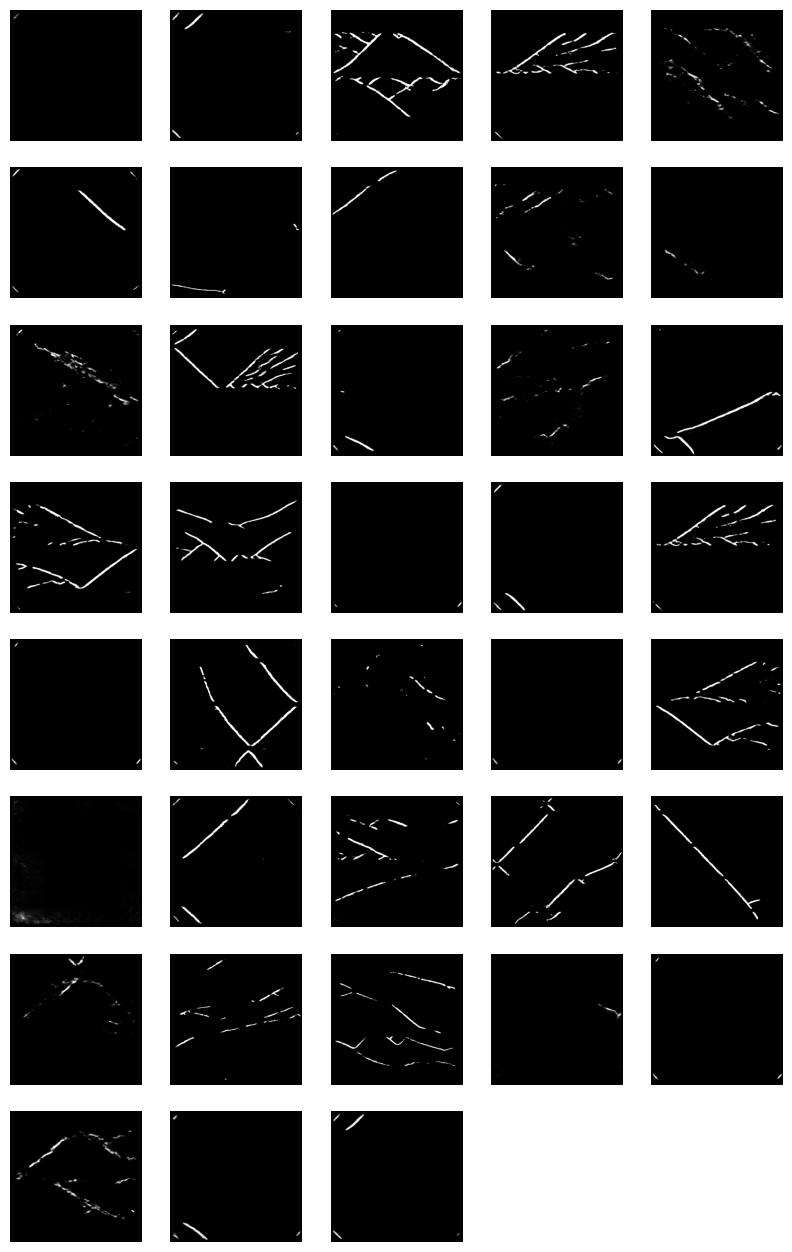

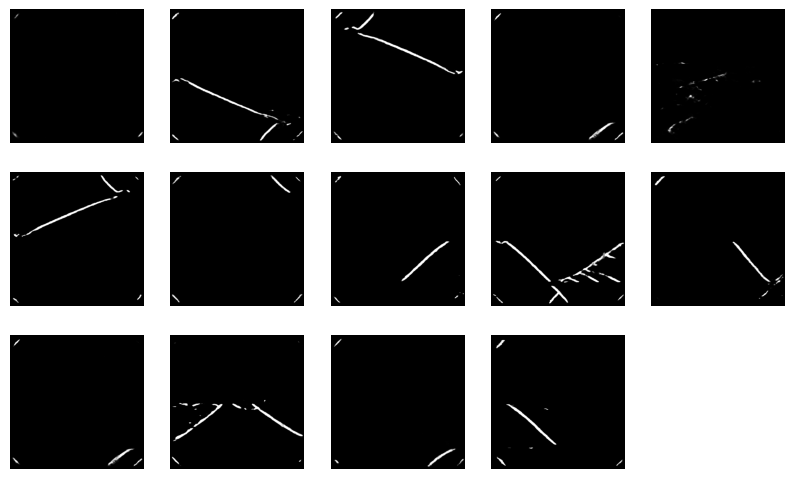

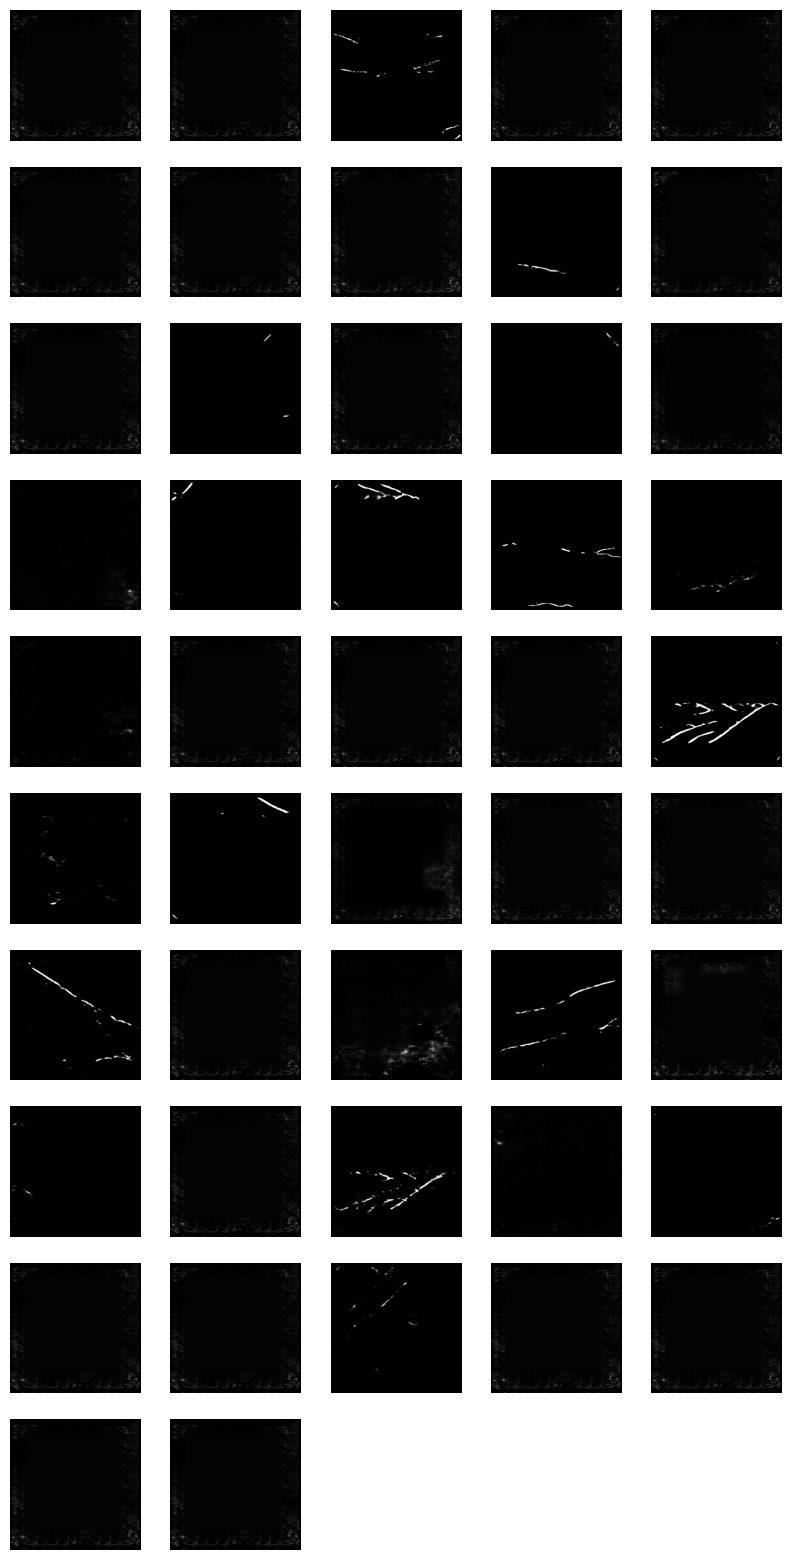

In [32]:
#Show HDBSCAN clusters
path = os.getcwd()
def show_cluster_images(data, label, path, device):
    nspace = data.query(f"k_label == '{label}'")
    nspace_vectors = nspace['latent_vectors'].tolist()
    nspace_tensors = torch.tensor(nspace_vectors).to(device)
    generated_images = model.decoder(nspace_tensors)
    fig = show_generated_images(generated_images, len(generated_images), path)
    return fig, generated_images, nspace_vectors
    

#Generate images of latent vectors for each cluster to see whats up with them
lspace = pd.DataFrame({'latent_vectors' : data_reshape.tolist(), 'k_label' : labels})

#sort for each label and geenrate images
fig, cluster0images, cluster0vectors = show_cluster_images(lspace, 0, path, device)
fig2, cluster1images, cluster1vectors = show_cluster_images(lspace, 1, path, device)
fig3, cluster2images, cluster2vectors = show_cluster_images(lspace, 2, path, device)
# fig4, cluster3images, cluster3vectors = show_cluster_images(lspace, 3, path, device)
# fig5, cluster4images, cluster4vectors = show_cluster_images(lspace, 4, path, device)
# fig6, cluster0images = show_cluster_images(lspace, 5, device)
# fig7, cluster1images = show_cluster_images(lspace, 6, device)
# fig8, cluster2images = show_cluster_images(lspace, 7, device)
# fig9, cluster3images = show_cluster_images(lspace, 8, device)
# fig10, cluster4images = show_cluster_images(lspace, 9, device)


In [33]:
#t-test for features from HDBSCAN clusters
#Looks like cluster 4 shows good results
def ttest_features(data_in, data_out):
    from scipy.stats import ttest_ind
    #Run on detected features from the dataframe
    columns_of_interest = [' prop.perimeter', ' slope', ' prop.convex_area', ' prop.area',
           ' prop.orientation']
    
    # Extract the data from the dataframes
    data1 = data_in[columns_of_interest].apply(pd.to_numeric, errors='coerce')
    data1 = data1.values
    data2 = data_out[columns_of_interest].apply(pd.to_numeric, errors='coerce')
    data2 = data2.values
    
    # Perform independent two-sample t-test for each column
    t_stats = []
    p_values = []
    
    for col in range(data1.shape[1]):
        t_stat, p_value = ttest_ind(data1[:, col], data2[:, col])
        t_stats.append(t_stat)
        p_values.append(p_value)

    pmean = np.mean(p_values)
    tmean = np.mean(t_stats)

    # Display results
    for col, t_stat, p_value in zip(columns_of_interest, t_stats, p_values):
        print(f"Column: {col}, t-statistic: {t_stat.round(5)}, p-value: {p_value.round(5)}")
    print(f"Mean t-stats = {tmean.round(5)}, mean p-values = {pmean.round(5)}")

dic_image_klabel = {'k_label' : klabels, 'input_image' : testimgs}

    
#cluster 0
print("Cluster 0 features t-test")
output = cluster0images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 1
print("Cluster 1 features t-test")
output = cluster1images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

#cluster 2
print("Cluster 2 features t-test")
output = cluster2images.to('cpu').detach().numpy()
output = np.reshape(output, (len(output), 400, 400, 1))
input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
input = np.reshape(input, (len(input), 400, 400, 1))
dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
ttest_features(dffeaturesreal, dffeaturesout)

# #cluster 3
# print("Cluster 3 features t-test")
# output = cluster3images.to('cpu').detach().numpy()
# output = np.reshape(output, (len(output), 400, 400, 1))
# input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
# input = np.reshape(input, (len(input), 400, 400, 1))
# dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
# dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
# ttest_features(dffeaturesreal, dffeaturesout)

# #cluster 4
# print("Cluster 4 features t-test")
# output = cluster4images.to('cpu').detach().numpy() 
# output = np.reshape(output, (len(output), 400, 400, 1))
# input = np.array([img for k, img in zip(dic_image_klabel['k_label'], dic_image_klabel['input_image']) if k == 0])
# input = np.reshape(input, (len(input), 400, 400, 1))
# dffeaturesreal = features.feature_extraction_crack_mask(input, dfinfo)
# dffeaturesout  = features.feature_extraction_crack_mask(output, dfinfo)
# ttest_features(dffeaturesreal, dffeaturesout)

Cluster 0 features t-test
Column:  prop.perimeter, t-statistic: 3.63593, p-value: 0.00037
Column:  slope, t-statistic: 1.67793, p-value: 0.0953
Column:  prop.convex_area, t-statistic: 3.50726, p-value: 0.00059
Column:  prop.area, t-statistic: 3.97894, p-value: 0.0001
Column:  prop.orientation, t-statistic: 1.37241, p-value: 0.17184
Mean t-stats = 2.8345, mean p-values = 0.05364
Cluster 1 features t-test
Column:  prop.perimeter, t-statistic: 2.64018, p-value: 0.01015
Column:  slope, t-statistic: 3.62123, p-value: 0.00054
Column:  prop.convex_area, t-statistic: 2.30771, p-value: 0.02389
Column:  prop.area, t-statistic: 2.50796, p-value: 0.0144
Column:  prop.orientation, t-statistic: 2.40637, p-value: 0.01868
Mean t-stats = 2.69669, mean p-values = 0.01353
Cluster 2 features t-test
Column:  prop.perimeter, t-statistic: -2.25659, p-value: 0.0255
Column:  slope, t-statistic: 0.48467, p-value: 0.62862
Column:  prop.convex_area, t-statistic: -2.48575, p-value: 0.01404
Column:  prop.area, t-st

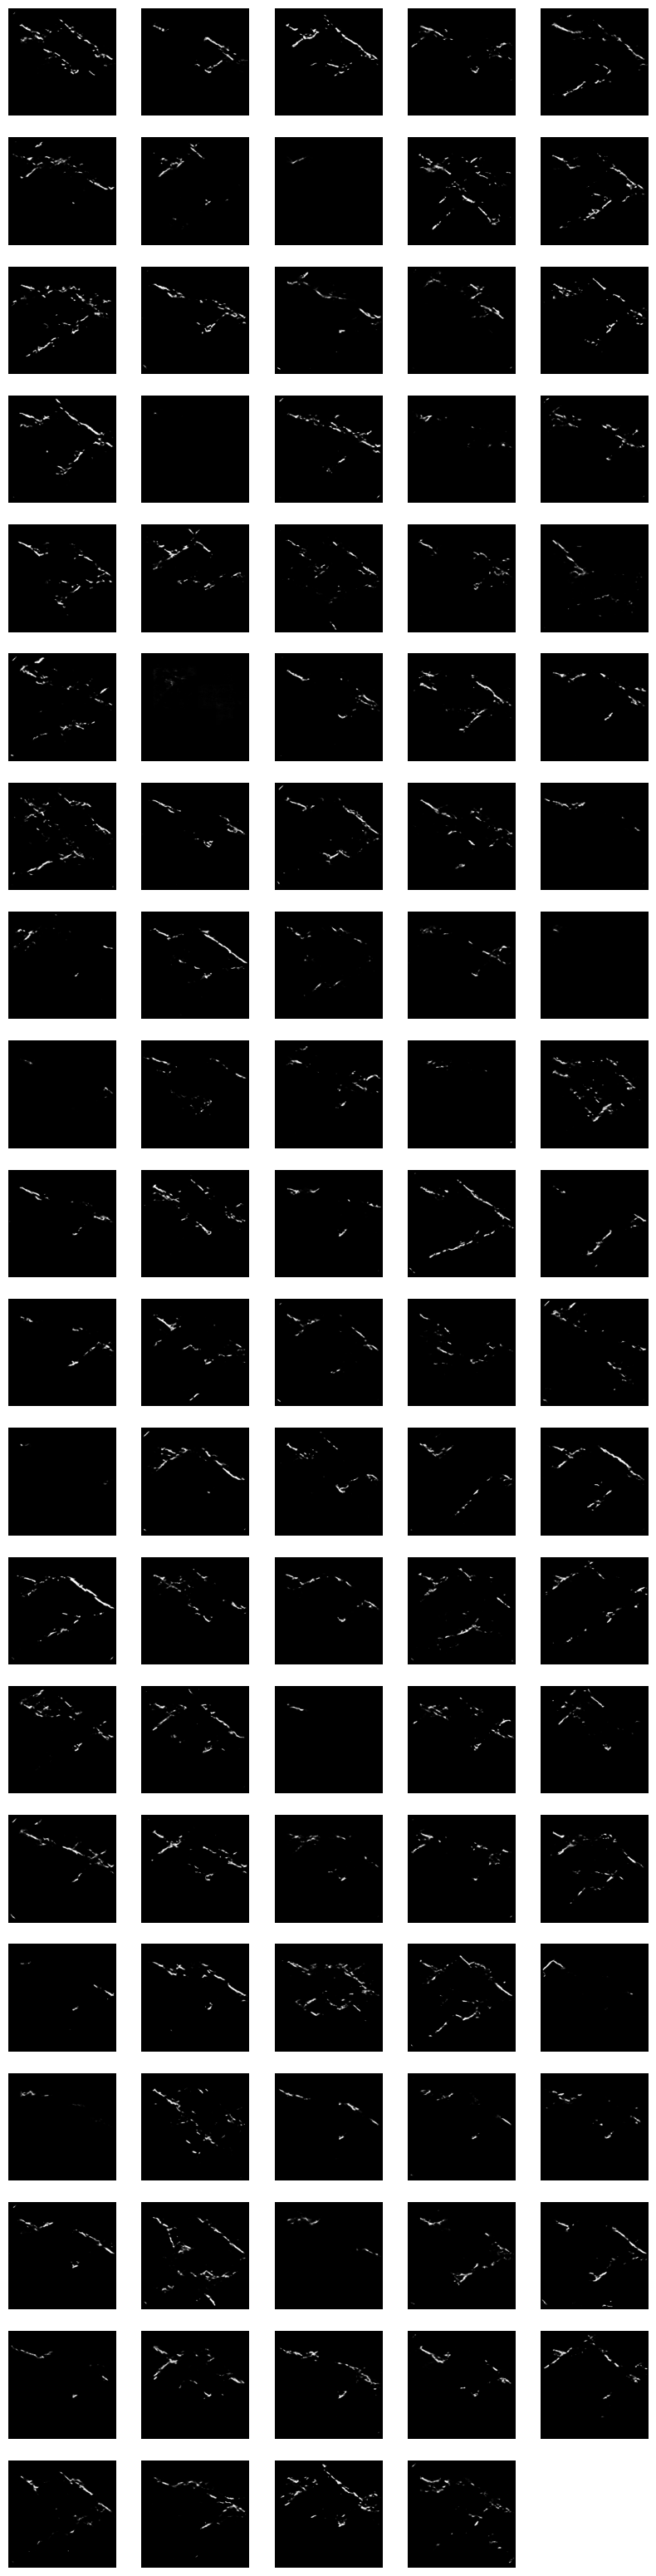

In [34]:
#Generate from HDBSCAN clustering
#which cluster wins??? 2
#create latent vectors similar to winning cluster
#images don't look better as previously generated
import random
clustered_latent_vectors = cluster2vectors  # Your clustered latent vectors here

# Calculate the mean vector of the selected vectors or use centroid from k-means
mean_vector = np.max(clustered_latent_vectors, axis=0)
# mean_vector = pca.inverse_transform(centroids[4]) #from 3 dimensions to 50 using PCA

# Create 262 new vectors
num_new_vectors = 99
new_latent_vectors = []

for _ in range(num_new_vectors):
    original_latent_vectors = np.array(clustered_latent_vectors)
    
    # Randomly choose a vector from the original set
    original_vector = original_latent_vectors[random.randint(0, len(original_latent_vectors)-1)]

    # Calculate the difference between the chosen vector and the mean
    diff = original_vector - mean_vector

    # Add or subtract this difference to create a new vector
    top_bot = 1 #spread of new vector in latent space
    new_vector = mean_vector + np.random.uniform(-top_bot, +top_bot, 50) * diff
    # new_vector = mean_vector + top_bot * diff

    # Append the new vector to the list
    new_latent_vectors.append(new_vector)

# Convert the result to a NumPy array
new_latent_vectors = np.array(new_latent_vectors)
new_latent_vectors_list = new_latent_vectors.tolist() #include this otherwise you get type error

#convert to tensors
generated_latent_tensors = torch.tensor(new_latent_vectors_list)
generated_images = model.decoder(generated_latent_tensors.to(device))
fig = show_generated_images(generated_images, len(generated_images), path)
